
### Project Description:


ABC Group (an arbitrary name) is a multinational corporate. Its business covers foods, real estate, property management and digital entertainment. And ABC group is considering expanding its business into Denver, a city with a hugely increasing number of immigrants, highly educated labors, travelers,  and tech companies. The diverse communities of Denver indicate both promising opportunities and potentials for business. 
However, the information at hands for management is limited and far enough to the final decision. In order to penetrate the Denver market, a preliminary analysis is requested by the management. The purpose of this analysis is to better understand the dynamics of Denver neighborhoods and reveal potential business opportunities. Tracy Liu, as an analyst in ABC Group, will be responsible for this analysis and answer the following questions:

- What is the dynamics of Denver neighborhoods
- What kind of business is recommended
- Where or which neighborhood to start the business


### Information Description:


To answer the questions and generate meaningful information for the final business decision, the following information is analyzed:

1. The dynamics of Denver business market
2. The crime history of Denver Neighborhoods


### Data Description:

#### The dynamics of Denver business market:

- Data Source: [Opendatasoft](https://public.opendatasoft.com/explore/dataset/zillow-neighborhoods/export/?q=Denver&refine.state=CO&refine.city=Denver)
    - Data Description: Denver neighborhoods name, latitudes and longitude
- Data Source: Four Square Database
    - Data Description: Venues (type of business) and categories data is retrived from the Four Square Database, then clustering methodology is used to group neighborhoods together with high similarities

#### The crime history of Denver Neighborhoods

- Data Source: [Denver Government Website](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-crime)
- Data Descritpion: Crimes hishory data is retrived from Denver government website, the information is then generarated to understand the crime history and trend in neighborhoods.




In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt
import matplotlib as mpl


from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score

print('Libraries imported.')

Libraries imported.


## The dynamics of Denver business market


1. [Create Denver Neighoborhoods Dataframe](#Create-Denver-Neighborhoods-Dataframe)
<ol>
1. Download the Denver Neighborhoods geojson file from [https://public.opendatasoft.com/](https://public.opendatasoft.com/explore/dataset/zillow-neighborhoods/export/?q=Denver&refine.state=CO&refine.city=Denver) And read it into Denver_data dataset
2. Exam the dataset and create a new list neighborhoods_data with values from 'properties' key
3. Create an empty dataframe neighborhoods, input the city, county, neighborhood name, latitude and longitude data into the datafrom from neighborhoods_data list, exam the dataframe.
4. Visualize the neighoborhoods
</ol>
2. [Cluster the Denver Neighborhoods](#Cluster-the-Denver-Neighborhoods)
<ol>
1. Create the FourSquare Creadention
2. Get the neighborhoods venues and import into dataframe: Den_venues
3. Prepare the dataframe for clustering
4. Use K-means clustering to cluster the neighborhoods
5. Use Agglomemarive Clustering to cluster the neighborhoods
6. Summary of clustering results
</ol>
3. [Analyze the Clusters](#Analyze-the-Clusters)
<ol>
1. Create a dataframe that combine the average frequency and cluster label of each neighborhood
2. Create a dataframe with average frequency of each label
3. Obtain the top 10 venues by average frequency of each lable
4. Business Consideration from Clusters
</ol>


## Create Denver Neighborhoods Dataframe

#### Load the geojson file

In [17]:
with open('zillow-neighborhoods.geojson') as json_data:
    Denver_data = json.load(json_data)

Quick check

In [19]:
Denver_data['features'][0]['properties']

{'city': 'Denver',
 'name': 'Wellshire',
 'regionid': '268775',
 'geo_point_2d': [39.66055714600584, -104.94958065349705],
 'county': 'Denver',
 'state': 'CO'}

#### Data needed: City, county,name, geo_point_2d, all is under the features key, then create a new variable for this data

In [20]:
neighborhoods_data = Denver_data['features']

#### Transform the data needed into dataframe

In [21]:
# define the dataframe columns
column_names = ['City', 'County','Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,City,County,Neighborhood,Latitude,Longitude


Create a loop to fill the data into dataframe

In [22]:
for data in neighborhoods_data:
    city = data['properties']['city']
    county = data['properties']['county']
    neighborhood = data['properties']['name']
    neighborhood_latlon = data['properties']['geo_point_2d']
    neighborhood_lat = neighborhood_latlon[0]
    neighborhood_lon = neighborhood_latlon[1]
    
    neighborhoods = neighborhoods.append({'City': city,
                                          'County': county,
                                          'Neighborhood':neighborhood,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head(5)

,City,County,Neighborhood,Latitude,Longitude
0,Denver,Denver,Wellshire,39.660557,-104.949581
1,Denver,Denver,College View - South Platte,39.672460,-105.013201
2,Denver,Denver,West Highland,39.764113,-105.039244
3,Denver,Denver,Whittier,39.756362,-104.966544
4,Denver,Denver,Ruby Hill,39.689994,-105.011162


In [23]:
print(neighborhoods.shape)
print(neighborhoods.info())

(79, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 5 columns):
City            79 non-null object
County          79 non-null object
Neighborhood    79 non-null object
Latitude        79 non-null float64
Longitude       79 non-null float64
dtypes: float64(2), object(3)
memory usage: 3.2+ KB
None


#### Exam the dataframe: Check for duplicate values

In [24]:
neighborhoods['Neighborhood'].value_counts().head()

Hampden       2
Hilltop       1
Hale          1
Fort Logan    1
Marston       1
Name: Neighborhood, dtype: int64

2 Hampden neighborhoods, drop the one from Arapahoe county <br>
DIA neighborhood is the neighborhood of Denver International Airport, it is different from the rest of neighborhoods due to its functionality. So I drop the DIA neighborhood with its relative information

In [25]:
neighborhoods = neighborhoods[neighborhoods['County'] == 'Denver']
neighborhoods = neighborhoods[neighborhoods['Neighborhood'] != 'DIA']

In [26]:
print(neighborhoods.shape)
print(neighborhoods.info())

(77, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 78
Data columns (total 5 columns):
City            77 non-null object
County          77 non-null object
Neighborhood    77 non-null object
Latitude        77 non-null float64
Longitude       77 non-null float64
dtypes: float64(2), object(3)
memory usage: 3.6+ KB
None


#### Visualize the Denver neighborhoods

Get the geography coordinates of Denver

In [27]:
address = 'Denver, CO'

geolocator = Nominatim(user_agent="tot_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Denver are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Denver are 39.7392364, -104.9848623.


In [28]:
# create map of Manhattan using latitude and longitude values
map_den = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_den)  
    
map_den

Denver neighborhoods data is ready to use

## Cluster the Denver Neighborhoods

For some reason the FourSquare API is easy to breakdown, which leads me to re-run the API multiple times and easily run out of daily limit, so I export the Den_venues dataframe after a successful run and import it for convenience. For review purpose, please skip the following process:

- Create the FourSquare credendtial
- Get all the venues of Denver neighborhood and create a new dataframe Den_venues

In [29]:
#Den_venues.to_csv('Den_venues.csv', index = False)
#Den_venues = pd.read_csv('Den_venues.csv')

#### Create the FourSquare creadential (Please skip)

#### Get all the venues of Denver neighborhood and create a new dataframe Den_venues (Please Skip)

According to [Wikipedia](https://en.wikipedia.org/wiki/Denver#Neighborhoods), A total of 78 counties occupy 155 square miles (401 km2) of area, using math then we can get the average radius of each county: 2km or 2000 meters. [Denver population](https://worldpopulationreview.com/us-cities/denver-population/) is about 0.7 million, making up about 13% of total population of [Colorado State](https://kdvr.com/news/local/colorados-population-expected-to-reach-5-8-million-in-2020/). [The number of small business in Colorado in 2018](https://www.sba.gov/sites/default/files/advocacy/2018-Small-Business-Profiles-CO.pdf) is about 610,000, using the population percentage we can approximate the number of small business in Denver, which is 610,000 * 0.13 = 79,300, then each neighborhood has about 1,016 small business.

- According to the information and approximation above, set up the radius as 2000 (meters) and limit as 1000
- After trying multiple times, I soon find out that the max venue output is 100, so limit here can be any number larger than 100

In [15]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = 'YEARMONTHDAY,' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000, limit = 700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            limit
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [59]:
Den_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )


Wellshire
College View - South Platte
West Highland
Whittier
Ruby Hill
Goldsmith
Hampden South
Congress Park
Platt Park
Globeville
Hampden
North Park Hill
Kennedy
Civic Center
Windsor
Highland
Country Club
Regis
Hale
Elyria Swansea
Sloan Lake
Sunnyside
Union Station
Harvey Park South
West Colfax
Berkeley
Indian Creek
Lincoln Park
Baker
Villa Park
Cherry Creek
Barnum
Rosedale
Hilltop
City Park
Auraria
Central Business District
Cheesman Park
Gateway - Green Valley Ranch
University Hills
Five Points
Barnum West
Belcaro
Skyland
Virginia Village
Speer
Westwood
Washington Park
Washington Park West
Marston
University Park
Harvey Park
City Park West
Cory - Merrill
Valverde
Athmar Park
Chaffee Park
Sun Valley
South Park Hill
Mar Lee
Lowry Field
Washington Virginia Vale
Overland
East Colfax
Capitol Hill
Jefferson Park
Clayton
North Capitol Hill
Northeast Park Hill
Cole
Southmoor Park
University
Montclair
Stapleton
Fort Logan
Bear Valley
Montbello


Check the dataframe

In [30]:
print(Den_venues.shape)

(6778, 7)


In [31]:
Den_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wellshire,39.660557,-104.949581,Chipotle Mexican Grill,39.666417,-104.939887,Mexican Restaurant
1,Wellshire,39.660557,-104.949581,Patxi's Chicago Pizza,39.654451,-104.959771,Pizza Place
2,Wellshire,39.660557,-104.949581,Glacier Ice Cream,39.654489,-104.959988,Ice Cream Shop
3,Wellshire,39.660557,-104.949581,Sprouts Farmers Market,39.664247,-104.939432,Grocery Store
4,Wellshire,39.660557,-104.949581,Schlessman Family YMCA,39.668171,-104.941526,Recreation Center


Count the number of venues for each neighborhood, max venue is 100

In [32]:
Venue_count = Den_venues.groupby('Neighborhood').count()
Venue_count = Venue_count.reset_index()
Venue_count = Venue_count.iloc[:,[0,-1]]
Venue_count

,Neighborhood,Venue Category
0,Athmar Park,86
1,Auraria,100
2,Baker,100
3,Barnum,87
4,Barnum West,48
5,Bear Valley,74
6,Belcaro,100
7,Berkeley,100
8,Capitol Hill,100
9,Central Business District,100


In [33]:
Venue_count[['Venue Category']].describe()

,Venue Category
count,77.000000
mean,88.025974
std,18.641334
min,38.000000
25%,74.000000
50%,100.000000
75%,100.000000
max,100.000000


Median is 100, larger than mean, which is 88. This indicates that more than half of neighborhoods have 100 categories

In [34]:
print('There are {} uniques categories.'.format(len(Den_venues['Venue Category'].unique())))

There are 300 uniques categories.


#### Prepare the dataframe for clustering

- Use one-hot coding to convert categorical variable (venue) into binary variable
- Group by the neighborhood using the average frequency of each venue category
    - The average frequency is used by the machine learning algorithm to determine the similarities among neighborhoods
- Find out the top 30 venues and for each neighbor and conver into data frame

In [35]:
# one hot encoding
Den_onehot = pd.get_dummies(Den_venues[['Venue Category']], prefix="", prefix_sep="")
# Add and move neighborhood column to the first column,since the category contains 'Neighborhood', the first column is renamed
# into 'Neighborhood_idx'
Den_onehot.insert(loc=0, column='Neighborhood_idx', value=Den_venues['Neighborhood'])

Den_onehot.head()

,Neighborhood_idx,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pool Hall,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Shop,Smoke Shop,Smoothie Shop,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trade School,Trail,Train Station,U

In [36]:
# Get the average frequency
Den_grouped = Den_onehot.groupby('Neighborhood_idx').mean().reset_index()
print(Den_grouped.shape)

(77, 301)


In [37]:
Den_grouped.head()

,Neighborhood_idx,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pool Hall,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Shop,Smoke Shop,Smoothie Shop,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trade School,Trail,Train Station,U

Montbello neighborhood has the least number of categories as 38, let's take top 30 categories

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [39]:
num_top_venues = 30

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Den_grouped['Neighborhood_idx']

for ind in np.arange(Den_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Den_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
0,Athmar Park,Vietnamese Restaurant,Mexican Restaurant,Marijuana Dispensary,Dim Sum Restaurant,Convenience Store,Coffee Shop,Clothing Store,Pharmacy,Discount Store,Chinese Restaurant,Liquor Store,Park,Thai Restaurant,Grocery Store,Bar,Sandwich Place,Furniture / Home Store,Music Venue,Supermarket,Food Truck,Flower Shop,Martial Arts Dojo,Distillery,Bakery,Rental Service,Farmers Market,Burger Joint,Residential Building (Apartment / Condo),Cajun / Creole Restaurant,Breakfast Spot
1,Auraria,Brewery,Hotel,Coffee Shop,American Restaurant,Theme Park Ride / Attraction,Italian Restaurant,Park,Theater,Mexican Restaurant,Burger Joint,Café,Sandwich Place,Pizza Place,Japanese Restaurant,Sushi Restaurant,Ice Cream Shop,Lounge,Steakhouse,New American Restaurant,Diner,Plaza,Museum,Spa,Bike Shop,Music Venue,Concert Hall,Neighborhood,Bookstore,Seafood Restaurant,Opera House
2,Baker,Bar,Mexican Restaurant,American Restaurant,Pizza Place,Italian Restaurant,Marijuana Dispensary,Coffee Shop,Brewery,Salon / Barbershop,Art Gallery,Asian Restaurant,Thrift / Vintage Store,Dive Bar,Clothing Store,Park,Breakfast Spot,Japanese Restaurant,Residential Building (Apartment / Condo),Shipping Store,Sandwich Place,Latin American Restaurant,Lingerie Store,Smoke Shop,Bookstore,Restaurant,Café,Liquor Store,Event Space,Sports Bar,Cajun / Creole Restaurant
3,Barnum,Mexican Restaurant,Convenience Store,Vietnamese Restaurant,Fast Food Restaurant,Marijuana Dispensary,Dim Sum Restaurant,Discount Store,Park,Liquor Store,Taco Place,Sandwich Place,Grocery Store,American Restaurant,Coffee Shop,Pharmacy,Diner,Light Rail Station,Food Truck,Supermarket,Food & Drink Shop,Steakhouse,Food,Pizza Place,Cajun / Creole Restaurant,Brewery,Shopping Mall,Burger Joint,Bakery,Mobile Phone Shop,Intersection
4,Barnum West,Mexican Restaurant,Convenience Store,Discount Store,Fast Food Restaurant,Liquor Store,American Restaurant,Park,Vietnamese Restaurant,Pet Store,Steakhouse,Mobile Phone Shop,Marijuana Dispensary,Burger Joint,Museum,Diner,Baseball Field,Basketball Court,Sandwich Place,Food & Drink Shop,Thrift / Vintage Store,Gas Station,Intersection,Food,Coffee Shop,Shopping Mall,Grocery Store,Home Service,Playground,Hobby Shop,Light Rail Station
5,Bear Valley,Pizza Place,Hotel,Coffee Shop,Liquor Store,Mexican Restaurant,Convenience Store,Sandwich Place,Bar,Bank,Fast Food Restaurant,Gym / Fitness Center,Chinese Restaurant,Breakfast Spot,ATM,Park,Vietnamese Restaurant,Shipping Store,Seafood Restaurant,Salon / Barbershop,Restaurant,American Restaurant,Pharmacy,Pet Store,Vegetarian / Vegan Restaurant,Cosmetics Shop,Organic Grocery,Dance Studio,Department Store,Dessert Shop,Discount Store
6,Belcaro,Coffee Shop,American Restaurant,Park,Mexican Restaurant,Italian Restaurant,Furniture / Home Store,Hotel,Burger Joint,Sandwich Place,Marijuana Dispensary,Cosmetics Shop,Bookstore,Gym / Fitness Center,Gym,Grocery Store,New American Restaurant,Kitchen Supply Store,Liquor Store,Fast Food Restaurant,Big Box Store,Restaurant,Market,Discount Store,Pub,Chocolate Shop,Diner,Poke Place,Chinese Restaurant,Sports Bar,Gift Shop
7,Berkeley,Pizza Place,Brewery,Coffee Shop,Mexican Restaurant,Liquor Store,Breakfast Spot,Park,Italian Restaurant,Bar,Grocery Store,Taco Place,Bakery,Indian Restaurant,Burrito Place,Ice Cream Shop,Sandwich Place

#### Clustering the Neighborhoods using K-means clustering

1. Determine the K 
2. Clustering
3. Visulize the clusters

Determine the K <br>
Empirical Method:
A simple empirical method of finding number of clusters is Square root of N/2 where N is total number of data points, so that each cluster contains square root of 2 * N
Number of Cluster: (77/2)^(0.5) ~ 6 <br>
Elbow Method: Find the point where Sum of Squared distance change steeply

In [40]:
# Prepare the values by droping the neiborhood name column
Den_grouped = Den_grouped.drop(['Neighborhood_idx'], axis = 1)

In [41]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Den_grouped)
    Sum_of_squared_distances.append(km.inertia_)

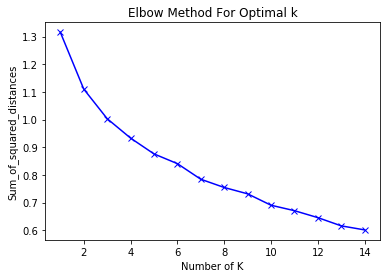

In [42]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of K')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Elbow method:
Number of Cluster: 6 <br>
Then use 6 as number of clusters

Cluster the neighborhoods

In [43]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Den_grouped)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 1, 1, 5, 5, 2, 1, 4, 1, 1])

In [44]:
# add clustering labels
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop(['K-means Cluster Labels'], axis = 1)
neighborhoods_venues_sorted.insert(0, 'K-means Cluster Labels', kmeans.labels_)

Den_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Den_merged = Den_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Den_merged.head() 

,City,County,Neighborhood,Latitude,Longitude,K-means Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
0,Denver,Denver,Wellshire,39.660557,-104.949581,2,Coffee Shop,Sandwich Place,Grocery Store,Pizza Place,Park,Bakery,Department Store,Pharmacy,Arts & Crafts Store,Golf Course,Bar,Pet Store,Shopping Plaza,Salon / Barbershop,Mexican Restaurant,Burrito Place,Mediterranean Restaurant,Café,Electronics Store,Sausage Shop,Gym / Fitness Center,Donut Shop,Recreation Center,Discount Store,Food Service,Playground,Concert Hall,Optical Shop,Paper / Office Supplies Store,Convenience Store
1,Denver,Denver,College View - South Platte,39.672460,-105.013201,0,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Convenience Store,Gas Station,Grocery Store,Storage Facility,Rental Car Location,Bank,Park,Food Truck,Pet Store,Music Venue,Light Rail Station,Sandwich Place,Business Service,Strip Club,Nightclub,Electronics Store,Restaurant,Discount Store,American Restaurant,Bowling Alley,Indie Theater,Art Gallery,Golf Course,Liquor Store,Ethiopian Restaurant,Drugstore,Event Service
2,Denver,Denver,West Highland,39.764113,-105.039244,4,Mexican Restaurant,Coffee Shop,Pizza Place,Brewery,Breakfast Spot,Park,Italian Restaurant,Bar,Liquor Store,Gym,Burrito Place,Sushi Restaurant,Bakery,Indian Restaurant,Ice Cream Shop,Thai Restaurant,Burger Joint,Vegetarian / Vegan Restaurant,Yoga Studio,Butcher,Deli / Bodega,Spa,Cuban Restaurant,Noodle House,New American Restaurant,Latin American Restaurant,Fast Food Restaurant,Organic Grocery,Diner,Café
3,Denver,Denver,Whittier,39.756362,-104.966544,4,Brewery,Bar,Coffee Shop,New American Restaurant,Café,American Restaurant,Zoo Exhibit,Pizza Place,Burger Joint,Breakfast Spot,Lounge,Italian Restaurant,Bakery,Ice Cream Shop,Gastropub,Sandwich Place,Gym,Park,Cocktail Bar,Diner,Food & Drink Shop,Sports Bar,French Restaurant,Southern / Soul Food Restaurant,Clothing Store,Food Truck,Jazz Club,Vegetarian / Vegan Restaurant,Pub,Bike Shop
4,Denver,Denver,Ruby Hill,39.689994,-105.011162,5,Vietnamese Restaurant,Convenience Store,Mexican Restaurant,Grocery Store,Fast Food Restaurant,Marijuana Dispensary,Discount Store,Thai Restaurant,Liquor Store,Massage Studio,Bank,Furniture / Home Store,Sandwich Place,Asian Restaurant,Chinese Restaurant,Gas Station,Park,Golf Course,Coffee Shop,Pizza Place,Nightclub,Brewery,Sports Bar,Financial or Legal Service,Martial Arts Dojo,Pharmacy,Breakfast Spot,Construction & Landscaping,Music Venue,Dim Sum Restaurant


In [45]:
Den_merged['K-means Cluster Labels'].value_counts()

2    28
1    17
4    15
5     7
0     7
3     3
Name: K-means Cluster Labels, dtype: int64

Visulize the Clusters

In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Den_merged['Latitude'], Den_merged['Longitude'], Den_merged['Neighborhood'], Den_merged['K-means Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Notice that cluster 0, which is the largest cluster, have three sub-clusters, one located in Northwest region, one in East region, and one in south region.
Also there is 1 outlier, Montebello neighborhood.
K-means should produce the sphere-like clusters, hence I will also try other algorithms to see if the clusters are more clear

#### Clustering the neighborhoods using Agglomerative clustering

In [47]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [48]:
X = Den_grouped.values

In [49]:
agglom = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
agglom.fit(X)
agglom.labels_

array([0, 3, 3, 0, 0, 2, 3, 1, 3, 3, 1, 3, 3, 5, 3, 3, 1, 4, 0, 3, 2, 3,
       2, 1, 4, 2, 2, 4, 2, 2, 2, 2, 0, 2, 1, 2, 2, 1, 2, 3, 2, 0, 2, 0,
       2, 3, 2, 2, 1, 1, 1, 1, 0, 5, 1, 2, 2, 3, 2, 1, 1, 3, 1, 2, 2, 0,
       0, 2, 3, 3, 2, 2, 1, 1, 0, 4, 2], dtype=int64)

In [50]:
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop(['Agg Cluster Labels'], axis = 1)
neighborhoods_venues_sorted.insert(0, 'Agg Cluster Labels', agglom.labels_)

Den_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Den_merged = Den_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Den_merged.head() 

,City,County,Neighborhood,Latitude,Longitude,Agg Cluster Labels,K-means Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
0,Denver,Denver,Wellshire,39.660557,-104.949581,2,2,Coffee Shop,Sandwich Place,Grocery Store,Pizza Place,Park,Bakery,Department Store,Pharmacy,Arts & Crafts Store,Golf Course,Bar,Pet Store,Shopping Plaza,Salon / Barbershop,Mexican Restaurant,Burrito Place,Mediterranean Restaurant,Café,Electronics Store,Sausage Shop,Gym / Fitness Center,Donut Shop,Recreation Center,Discount Store,Food Service,Playground,Concert Hall,Optical Shop,Paper / Office Supplies Store,Convenience Store
1,Denver,Denver,College View - South Platte,39.672460,-105.013201,0,0,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Convenience Store,Gas Station,Grocery Store,Storage Facility,Rental Car Location,Bank,Park,Food Truck,Pet Store,Music Venue,Light Rail Station,Sandwich Place,Business Service,Strip Club,Nightclub,Electronics Store,Restaurant,Discount Store,American Restaurant,Bowling Alley,Indie Theater,Art Gallery,Golf Course,Liquor Store,Ethiopian Restaurant,Drugstore,Event Service
2,Denver,Denver,West Highland,39.764113,-105.039244,1,4,Mexican Restaurant,Coffee Shop,Pizza Place,Brewery,Breakfast Spot,Park,Italian Restaurant,Bar,Liquor Store,Gym,Burrito Place,Sushi Restaurant,Bakery,Indian Restaurant,Ice Cream Shop,Thai Restaurant,Burger Joint,Vegetarian / Vegan Restaurant,Yoga Studio,Butcher,Deli / Bodega,Spa,Cuban Restaurant,Noodle House,New American Restaurant,Latin American Restaurant,Fast Food Restaurant,Organic Grocery,Diner,Café
3,Denver,Denver,Whittier,39.756362,-104.966544,4,4,Brewery,Bar,Coffee Shop,New American Restaurant,Café,American Restaurant,Zoo Exhibit,Pizza Place,Burger Joint,Breakfast Spot,Lounge,Italian Restaurant,Bakery,Ice Cream Shop,Gastropub,Sandwich Place,Gym,Park,Cocktail Bar,Diner,Food & Drink Shop,Sports Bar,French Restaurant,Southern / Soul Food Restaurant,Clothing Store,Food Truck,Jazz Club,Vegetarian / Vegan Restaurant,Pub,Bike Shop
4,Denver,Denver,Ruby Hill,39.689994,-105.011162,0,5,Vietnamese Restaurant,Convenience Store,Mexican Restaurant,Grocery Store,Fast Food Restaurant,Marijuana Dispensary,Discount Store,Thai Restaurant,Liquor Store,Massage Studio,Bank,Furniture / Home Store,Sandwich Place,Asian Restaurant,Chinese Restaurant,Gas Station,Park,Golf Course,Coffee Shop,Pizza Place,Nightclub,Brewery,Sports Bar,Financial or Legal Service,Martial Arts Dojo,Pharmacy,Breakfast Spot,Construction & Landscaping,Music Venue,Dim Sum Restaurant


In [51]:
Den_merged['Agg Cluster Labels'].value_counts()

2    27
3    17
1    16
0    11
4     4
5     2
Name: Agg Cluster Labels, dtype: int64

Visualize the clusters

In [52]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Den_merged['Latitude'], Den_merged['Longitude'], Den_merged['Neighborhood'], Den_merged['Agg Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Summary of Clustering results


1. Visual Comparison
<ol>
- Notice that the second biggest clusters from the two algorithms have exactly the same neighborhoods. The biggest cluster from Agglomerative clustering have 1 less neighborhoods. 
- In the output Agglomerative clustering, Cluster 1 distributed in Northwest and South region.
- There is still 1 outlier, the Montebello neighbohoods
- Visually compare the two algorithms, Agglomerative is better, it produced clear clusters
</ol>


| K-means Cluster | Neighborhoods | Agg Cluster - ward linkage | Neighborhoods |
|---|---|---|---|
|2  |  28| 2 | 27 |
|3  |  17| 3 | 17 |
|1  |  15| 1 | 16 |
|0  |  7 | 0 | 11 |
|4  |   7| 4 | 4  |
|5  |   3| 5 | 2  |






2. Evaluate the two models: Once clustering is done, how well the clustering has performed can be quantified by a number of metrics. Ideal clustering is characterised by minimal intra cluster distance and maximal inter cluster distance.There are majorly two types of measures to assess the clustering performance:
<ol>
1. Extrinsic Measures which require ground truth labels. Examples are Adjusted Rand index, Fowlkes-Mallows scores, Mutual information based scores, Homogeneity, Completeness and V-measure.
2. Intrinsic Measures that does not require ground truth labels. Some of the clustering performance measures are Silhouette Coefficient, Calinski-Harabasz Index, Davies-Bouldin Index etc.
</ol> 
<br>
Since there is no prior knowledge for neighborhoods, I use Intrinsic Measures to evaluate the two models:
<ol>
1. Silhouette Coefficient: a higher Silhouette Coefficient score relates to a model with better defined clusters
2. Calinski-Harabasz Index:  a higher Calinski-Harabasz score relates to a model with better defined clusters
3. Davies-Bouldin Index: a lower Davies-Bouldin index relates to a model with better separation between the clusters
</ol>


Detailed explanation and formulas for [Intrinsic Measures](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

In [53]:
k_labels = kmeans.labels_
agg_labels = agglom.labels_

Silhouette Coefficient

In [54]:
metrics.silhouette_score(Den_grouped, k_labels, metric='euclidean')
print('The K-means silhouette_score: {}'.format(metrics.silhouette_score(Den_grouped, k_labels, metric='euclidean')))
metrics.silhouette_score(X, agg_labels, metric='euclidean')
print('The Agglom silhouette_score: {}'.format(metrics.silhouette_score(X, agg_labels, metric='euclidean')))

The K-means silhouette_score: 0.121416031756513
The Agglom silhouette_score: 0.1306063199035374


Calinski-Harabasz Index

In [55]:
metrics.calinski_harabasz_score(Den_grouped, k_labels)
print('The K-means Calinski-Harabasz Index: {}'.format(metrics.calinski_harabasz_score(Den_grouped, k_labels)))
metrics.calinski_harabasz_score(X, agg_labels)
print('The Agglom Calinski-Harabasz Index: {}'.format(metrics.calinski_harabasz_score(X, agg_labels)))

The K-means Calinski-Harabasz Index: 8.177786576441273
The Agglom Calinski-Harabasz Index: 8.232882841289406


Davies-Bouldin Index

In [56]:
davies_bouldin_score(Den_grouped, k_labels)
print('The K-means Davies-Bouldin Index: {}'.format(davies_bouldin_score(Den_grouped, k_labels)))
davies_bouldin_score(X, agg_labels)
print('The Agglom Davies-Bouldin Index: {}'.format(davies_bouldin_score(X, agg_labels)))

The K-means Davies-Bouldin Index: 1.9052393299627661
The Agglom Davies-Bouldin Index: 1.813738882011263


From the three measurements above:
1. Agglomerative is better than K-means with higher Silhouette Coefficient
2. Agglomerative is better than K-means with higher Calinski-Harabasz Index
3. Agglomerative is better than K-means with lower Davies-Bouldin Index

Overall Agglomerative model is better than K-means and I will use the results from Agglomerative model for cluster analysis

## Analyze the Clusters



#### Create a dataframe that combine the average frequency and cluster label of each neighborhood

Regenerate a dataframe of average frequency of each neighborhood

In [57]:
Den_grouped_frequency = Den_onehot.groupby('Neighborhood_idx').mean().reset_index()

Add the cluster lable

In [58]:
merged_inner_2 = pd.merge(left = Den_merged[['Neighborhood', 'Agg Cluster Labels']], right = Den_grouped_frequency, how = 'inner', left_on = 'Neighborhood', right_on = 'Neighborhood_idx')

Format the table

In [59]:
merged_inner_2 = merged_inner_2.drop(['Neighborhood_idx'], axis = 1)
merged_inner_2.columns.values[0] = "Neighborhood"
merged_inner_2

,Neighborhood,Agg Cluster Labels,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood_y,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pool Hall,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Shop,Smoke Shop,Smoothie Shop,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trade School,Trai

#### Create a dataframe with average frequency of venue categories by each label

In [60]:
col_name = list(merged_inner_2.columns)[3:]

In [61]:
cluster_grouped = merged_inner_2.groupby('Agg Cluster Labels')[col_name].mean().reset_index()

In [62]:
cluster_grouped

,Agg Cluster Labels,Accessories Store,Adult Boutique,African Restaurant,Airport,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood_y,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pool Hall,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Shop,Smoke Shop,Smoothie Shop,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trade School,Trail,Train Station,U

#### Obtain the top 10 venues by average frequency of each lable

In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [64]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Agg Cluster']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cluster_venues_sorted = pd.DataFrame(columns=columns)
cluster_venues_sorted['Agg Cluster'] = cluster_grouped['Agg Cluster Labels']

for ind in np.arange(cluster_grouped.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cluster_grouped.iloc[ind, :], num_top_venues)

cluster_venues_sorted

,Agg Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Mexican Restaurant,Convenience Store,Vietnamese Restaurant,Fast Food Restaurant,Grocery Store,Discount Store,Marijuana Dispensary,Pizza Place,Gas Station,Sandwich Place
1,1,Mexican Restaurant,Coffee Shop,Brewery,Pizza Place,Park,Bar,Breakfast Spot,Convenience Store,Italian Restaurant,Marijuana Dispensary
2,2,Coffee Shop,Sandwich Place,Pizza Place,Mexican Restaurant,Park,Fast Food Restaurant,Convenience Store,Liquor Store,Grocery Store,Discount Store
3,3,American Restaurant,Coffee Shop,Mexican Restaurant,Italian Restaurant,Brewery,Sandwich Place,Pizza Place,Bar,Park,Hotel
4,4,Brewery,Bar,Coffee Shop,Pizza Place,Burger Joint,Cocktail Bar,New American Restaurant,Restaurant,Convenience Store,Park
5,5,Zoo Exhibit,Bar,Science Museum,Coffee Shop,Park,Greek Restaurant,Brewery,Pizza Place,Mexican Restaurant,American Restaurant


#### Business consideration from Clusters

Cluster 0: 
- 11 Neighborhoods
- Mexican Rsetaurant, Convenience Store, Vietnamese Restaurant, Fast Food Restaurant, Grocery Store, Discount Store, Pizza Place, Gast Station: Choice of cheap food, small amount purchase and maybe poor living environment
- Marijuana Dispensary: Indicator of crimes
![Cluster_0](Agg_cluster_0.PNG)


Cluster 1:
- 16 Neighborhoods
- Coffee, brewery, park, bar: Places to hang out and chill. 
- Mexican Restaurants, Pizza Places, and Convenience Store: A low living expenses. 
- Marijuana Dispensary: Indicator of crimes
- Italian Restaurants: Premium food consumptions 
![Cluster_1](Agg_cluster_1.PNG)

Cluster 2:

- 27 Neighborhoods
- Coffee shop, park: Place to hang out and chill
- Sandwich Place, Pizza Place, Mexican Restaurant, Fast Food Restaurant: Choice for cheap food
- Convenience Store, Liquor Store, Grocery Store, Discount Store: Small amount purchase
![Agg_2](Agg_cluster_2.PNG)


Cluster 3:

- 17 Neighborhoods:
- American Restaurant, Italian Restaurant: Premium food consumption
- Coffee Shop, Brewery, Park, Bar: Place to handout and chill
- Mexican Restaurant, Sandwich Place, Pizza Place: Choice for cheap food
- Hotel: Travelers' choice

![Agg_3](Agg_cluster_3.PNG)

Cluster 4:

- 4 Neighborhoods
- Brewery, Bar, Coffee Shop, Cocktail Bar, Park: Place to hang out and chill
- Burger Joint, New American Restaurant: Explore the different taste
- Convenience Store, Pizza Place: Choice for cheap food and small amount purchase

![Agg_4](Agg_cluster_4.png)

Cluster 5:

- 2 Neighborhoods
- Zoo Exhibit, Science Museum: Place for Learning and family activities
- Bar, Coffee Shop, Park, Brewery: Place to hang out and chill
- Greek Restaurant, American Restaurant: Diverse food consumption
- Pizza Place, Mexican Restaurant: Choice for cheap food

![Agg_5](Agg_cluster_5.PNG)

## The Crime History of Denver


1. [Clean the crime data and crate a dataframe for crime history in every cluster](#Data-Clean)
<ol>
1. Clean the crime dataframe
2. Clean the crime code dataframe
3. Combine both the two dataframe
</ol>
2. [Analysis of Denver neighborhood clusters crime history](#Analysis-of-Crime-History)
<ol>
1. Comparison of number of crimes by clusters
2. Create dataframe for each cluster
3. Analysis of Cluster 0
4. Analysis of Cluster 1
5. Analysis of Cluster 2
6. Analysis of Cluster 3
7. Analysis of Cluster 4
8. Analysis of Cluster 5
</ol>


## Data Clean


#### Import crime data file and crime code data file

In [68]:
Denver_crime_data = pd.read_csv('crime.csv')
crime_code = pd.read_csv('offense_codes.csv')

#### Exam both dataframe

In [69]:
print(Denver_crime_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486830 entries, 0 to 486829
Data columns (total 19 columns):
INCIDENT_ID               486830 non-null int64
OFFENSE_ID                486830 non-null int64
OFFENSE_CODE              486830 non-null int64
OFFENSE_CODE_EXTENSION    486830 non-null int64
OFFENSE_TYPE_ID           486830 non-null object
OFFENSE_CATEGORY_ID       486830 non-null object
FIRST_OCCURRENCE_DATE     486830 non-null object
LAST_OCCURRENCE_DATE      155228 non-null object
REPORTED_DATE             486830 non-null object
INCIDENT_ADDRESS          441162 non-null object
GEO_X                     482610 non-null float64
GEO_Y                     482610 non-null float64
GEO_LON                   482610 non-null float64
GEO_LAT                   482610 non-null float64
DISTRICT_ID               486830 non-null int64
PRECINCT_ID               486830 non-null int64
NEIGHBORHOOD_ID           486830 non-null object
IS_CRIME                  486830 non-null int64
IS_TRAFFIC

In [70]:
Denver_crime_data.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2018869789,2018869789239900,2399,0,theft-other,larceny,12/27/2018 3:58:00 PM,NaN,12/27/2018 4:51:00 PM,2681 N HANOVER CT,3178210.0,1700715.0,-104.866156,39.755561,5,512,stapleton,1,0
1,2015664356,2015664356544100,5441,0,traffic-accident,traffic-accident,11/13/2015 7:45:00 AM,NaN,11/13/2015 8:38:00 AM,4100 BLOCK W COLFAX AVE,3129148.0,1694748.0,-105.040760,39.739991,1,122,west-colfax,0,1
2,20176005213,20176005213239901,2399,1,theft-bicycle,larceny,6/8/2017 1:15:00 PM,6/8/2017 5:15:00 PM,6/12/2017 8:44:00 AM,1705 17TH ST,3140790.0,1699792.0,-104.999264,39.753669,6,612,union-station,1,0
3,20196012240,20196012240230800,2308,0,theft-from-bldg,larceny,12/7/2019 1:07:00 PM,12/7/2019 6:30:00 PM,12/9/2019 1:35:00 PM,1350 N IRVING ST,3132400.0,1694088.0,-105.029208,39.738134,1,122,west-colfax,1,0
4,2018861883,2018861883501600,5016,0,violation-of-restraining-order,all-other-crimes,12/22/2018 8:15:00 PM,12/22/2018 8:31:00 PM,12/22/2018 10:00:00 PM,13625 E RANDOLPH PL,3188580.0,1716158.0,-104.828868,39.797750,5,521,montbello,1,0


In [71]:
crime_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 8 columns):
OFFENSE_CODE              299 non-null int64
OFFENSE_CODE_EXTENSION    299 non-null int64
OFFENSE_TYPE_ID           299 non-null object
OFFENSE_TYPE_NAME         299 non-null object
OFFENSE_CATEGORY_ID       299 non-null object
OFFENSE_CATEGORY_NAME     299 non-null object
IS_CRIME                  299 non-null int64
IS_TRAFFIC                299 non-null int64
dtypes: int64(4), object(4)
memory usage: 18.8+ KB


In [72]:
crime_code.head()

,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_ID,OFFENSE_CATEGORY_NAME,IS_CRIME,IS_TRAFFIC
0,2804,1,stolen-property-possession,Possession of stolen property,all-other-crimes,All Other Crimes,1,0
1,2804,2,fraud-possess-financial-device,Possession of a financial device,all-other-crimes,All Other Crimes,1,0
2,2901,0,damaged-prop-bus,Damaged business property,public-disorder,Public Disorder,1,0
3,2902,0,criminal-mischief-private,Criminal mischief to private property,public-disorder,Public Disorder,1,0
4,2903,0,criminal-mischief-public,Criminal mischief to public property,public-disorder,Public Disorder,1,0


#### Clean the of crime dataframe
- Remove unnecessary columns from crime dataframe
- Convert the reported date from string type to datetime type
- Filter the crime only records
- Combine crime code and extension
- Remove '-' from neighborhood id and capitalize the first letter
- Add label to each neighborhood
- Check the missing value
- Drop dia neighborhood, insert labels to the neighborhoods with missing value
- Drop the unnecessary column and rename the index column
- check the number of neighborhoods in each label, align with the output from Agg label

In [73]:
Denver_crime_data.columns

Index(['INCIDENT_ID', 'OFFENSE_ID', 'OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION',
       'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'FIRST_OCCURRENCE_DATE',
       'LAST_OCCURRENCE_DATE', 'REPORTED_DATE', 'INCIDENT_ADDRESS', 'GEO_X',
       'GEO_Y', 'GEO_LON', 'GEO_LAT', 'DISTRICT_ID', 'PRECINCT_ID',
       'NEIGHBORHOOD_ID', 'IS_CRIME', 'IS_TRAFFIC'],
      dtype='object')

Remove the unnecessary columns

In [74]:
Denver_crime_data = Denver_crime_data[['INCIDENT_ID', 'OFFENSE_CODE','OFFENSE_CODE_EXTENSION','REPORTED_DATE','NEIGHBORHOOD_ID','IS_CRIME']]

In [75]:
Denver_crime_data = Denver_crime_data.copy()

Convert reprted date to datetime

In [76]:
Denver_crime_data['REPORTED_DATE'] = pd.to_datetime(Denver_crime_data['REPORTED_DATE'] ) 

Filter the crime data

In [77]:
Denver_crime_data = Denver_crime_data[Denver_crime_data['IS_CRIME']==1]

Create a new column by adding offense code and extention together

In [78]:
Denver_crime_data['OFFENSE_CODE_FULL'] = Denver_crime_data['OFFENSE_CODE'].map(str) + Denver_crime_data['OFFENSE_CODE_EXTENSION'].map(str)
Denver_crime_data['OFFENSE_CODE_FULL'] = Denver_crime_data['OFFENSE_CODE_FULL'].astype(int)

Remove '-' from neighborhood id and capitalize the fisrt letter

In [79]:
Denver_crime_data['NEIGHBORHOOD'] = Denver_crime_data['NEIGHBORHOOD_ID'].replace({"-": " "},regex=True)

In [80]:
Denver_crime_data['NEIGHBORHOOD'] = Denver_crime_data['NEIGHBORHOOD'].str.title()

Add the lable to each neighborhood

In [81]:
neighborhood_label = merged_inner_2[['Neighborhood','Agg Cluster Labels']]

In [82]:
Denver_crime_label = Denver_crime_data.set_index('NEIGHBORHOOD').join(neighborhood_label.set_index('Neighborhood')).reset_index()

check the missing value in labels

In [83]:
missing_lb = Denver_crime_label[['NEIGHBORHOOD_ID','Agg Cluster Labels']].drop_duplicates()
missing_lb[missing_lb['Agg Cluster Labels'].isnull()]

,NEIGHBORHOOD_ID,Agg Cluster Labels
42658,cbd,NaN
91745,college-view-south-platte,NaN
99940,cory-merrill,NaN
102348,dia,NaN
147514,gateway-green-valley-ranch,NaN


In [84]:
neighborhood_label.loc[neighborhood_label['Neighborhood'].isin(['Central Business District','College View - South Platte','Cory - Merrill','Gateway - Green Valley Ranch'])]

,Neighborhood,Agg Cluster Labels
1,College View - South Platte,0
36,Central Business District,3
38,Gateway - Green Valley Ranch,2
53,Cory - Merrill,2


Drop the Dia neighborhood, adding labels to the neighborhoods with missing values

In [85]:
Denver_crime_label = Denver_crime_label[Denver_crime_label['NEIGHBORHOOD_ID'] != 'dia']
Denver_crime_label.loc[Denver_crime_label['NEIGHBORHOOD_ID'] == 'cbd', 'Agg Cluster Labels'] = 3
Denver_crime_label.loc[Denver_crime_label['NEIGHBORHOOD_ID'] == 'college-view-south-platte', 'Agg Cluster Labels'] = 0
Denver_crime_label.loc[Denver_crime_label['NEIGHBORHOOD_ID'] == 'cory-merrill', 'Agg Cluster Labels'] = 2
Denver_crime_label.loc[Denver_crime_label['NEIGHBORHOOD_ID'] == 'gateway-green-valley-ranch', 'Agg Cluster Labels'] = 2

In [87]:
Denver_crime_label.head()

,index,INCIDENT_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,REPORTED_DATE,NEIGHBORHOOD_ID,IS_CRIME,OFFENSE_CODE_FULL,Agg Cluster Labels
0,Athmar Park,2015317996,2305,0,2015-06-08 16:15:00,athmar-park,1,23050,0.0
1,Athmar Park,2019317737,2399,0,2019-05-21 19:45:00,athmar-park,1,23990,0.0
2,Athmar Park,2018564640,3550,0,2018-08-18 22:36:00,athmar-park,1,35500,0.0
3,Athmar Park,2016687756,5499,0,2016-10-27 02:30:00,athmar-park,1,54990,0.0
4,Athmar Park,2015629361,5444,0,2015-10-27 18:03:00,athmar-park,1,54440,0.0


Drop unnecessary column and rename the index column

In [88]:
Denver_crime_label.rename(columns={'index':'Neighborhood'}, inplace=True)

In [89]:
Denver_crime_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356244 entries, 0 to 361941
Data columns (total 9 columns):
Neighborhood              356244 non-null object
INCIDENT_ID               356244 non-null int64
OFFENSE_CODE              356244 non-null int64
OFFENSE_CODE_EXTENSION    356244 non-null int64
REPORTED_DATE             356244 non-null datetime64[ns]
NEIGHBORHOOD_ID           356244 non-null object
IS_CRIME                  356244 non-null int64
OFFENSE_CODE_FULL         356244 non-null int32
Agg Cluster Labels        356244 non-null float64
dtypes: datetime64[ns](1), float64(1), int32(1), int64(4), object(2)
memory usage: 25.8+ MB


check the number of neighborhoods in each label, align with the output from Agg label

In [90]:
label_check = Denver_crime_label[['Neighborhood','Agg Cluster Labels']].drop_duplicates()
label_check['Agg Cluster Labels'].value_counts()

2.0    27
3.0    17
1.0    16
0.0    11
4.0     4
5.0     2
Name: Agg Cluster Labels, dtype: int64

#### Clean the crime code dataframe

- Combine the offense code and extension in crime code dataframe
- Drop unnecessary columns

Combine the offense code and extension in crime code dataframe

In [91]:
crime_code['OFFENSE_CODE_FULL'] = crime_code['OFFENSE_CODE'].map(str) + crime_code['OFFENSE_CODE_EXTENSION'].map(str)
crime_code['OFFENSE_CODE_FULL'] = crime_code['OFFENSE_CODE_FULL'].astype(int)

Drop unnecessary columns

In [92]:
crime_code = crime_code.iloc[:,[3,5,8]]

#### Join the crime and cime code datafrme

In [93]:
Denver_crime_label = Denver_crime_label.set_index('OFFENSE_CODE_FULL').join(crime_code.set_index('OFFENSE_CODE_FULL')).reset_index()

In [96]:
Denver_crime_label = Denver_crime_label.iloc[:,[1,5,8,9,10]]

In [97]:
Denver_crime_label.head()

,Neighborhood,REPORTED_DATE,Agg Cluster Labels,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_NAME
0,Baker,2018-07-23 03:42:00,3.0,Homicide by a family member,Murder
1,Bear Valley,2016-07-31 15:26:00,2.0,Homicide by a family member,Murder
2,Chaffee Park,2020-02-09 21:41:00,1.0,Homicide by a family member,Murder
3,City Park West,2019-05-31 17:33:00,3.0,Homicide by a family member,Murder
4,East Colfax,2017-03-18 04:12:00,2.0,Homicide by a family member,Murder


## Analysis of Crime History

For convenience, I exported the formatted Denver_crime_label dataframe and import here, so I don't need to re-run the precious codes everytime

In [131]:
#Denver_crime_label.to_csv('Denver_crime_label.csv', index = False)
#Denver_crime_label = pd.read_csv('Denver_crime_label.csv')

In [132]:
Denver_crime_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356244 entries, 0 to 356243
Data columns (total 6 columns):
Neighborhood             356244 non-null object
REPORTED_DATE            356244 non-null object
Agg Cluster Labels       356244 non-null float64
OFFENSE_TYPE_NAME        356244 non-null object
OFFENSE_CATEGORY_NAME    356244 non-null object
YEAR                     356244 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 16.3+ MB


In [133]:
Denver_crime_label['REPORTED_DATE'] = pd.to_datetime(Denver_crime_label['REPORTED_DATE'] ) 

Find out the timeframe of the crime history

In [134]:
Denver_crime_label['YEAR'] = Denver_crime_label['REPORTED_DATE'].dt.year

In [135]:
Denver_crime_label['YEAR'].unique()

array([2018, 2016, 2020, 2019, 2017, 2015], dtype=int64)

#### Comparison of number of crimes by clusters

Comparison between clusters

In [102]:
All_cluster_crime = Denver_crime_label.groupby(['Agg Cluster Labels'])['OFFENSE_CATEGORY_NAME'].count().reset_index()
All_cluster_crime.columns = ['Neighborhood Label','Count of Crimes']
All_cluster_crime  = All_cluster_crime.sort_values(by = 'Count of Crimes', ascending = False)
All_cluster_crime['Percentage'] = All_cluster_crime['Count of Crimes']/All_cluster_crime['Count of Crimes'].sum()
All_cluster_crime['Count of Crimes'] = All_cluster_crime['Count of Crimes'].apply(lambda x : '{0:,}'.format(x))
All_cluster_crime['Percentage']= All_cluster_crime['Percentage'].apply(lambda x: "{0:.0%}".format(x))
All_cluster_crime

,Neighborhood Label,Count of Crimes,Percentage
3,3.0,"104,171",29%
2,2.0,"100,918",28%
0,0.0,"61,198",17%
1,1.0,"54,656",15%
4,4.0,"32,099",9%
5,5.0,"3,202",1%


 - Cluster 2 and 3 have almost same percentage in terms of total crimes
 - Considering the number of neighborhoods, cluster 1 and cluster 3 have almost the same number of neighborhoods, but the number of crimes from cluster 3 is nearly twice the number from cluster 1
 - Cluster 0 and 1 are also very close

Comparison between crime categories

In [103]:
Total_crimes  = Denver_crime_label.groupby(['OFFENSE_CATEGORY_NAME'])['OFFENSE_CATEGORY_NAME'].count()
Total_crimes  = Total_crimes.to_frame()
Total_crimes.columns = ['Count_of_crimes']
Total_crimes  = Total_crimes.reset_index()
Total_crimes  = Total_crimes.sort_values(by = 'Count_of_crimes', ascending = False)
Total_crimes['Percentage'] = Total_crimes['Count_of_crimes']/Total_crimes['Count_of_crimes'].sum()
Total_crimes.Count_of_crimes = Total_crimes.Count_of_crimes.apply(lambda x : '{0:,}'.format(x))
Total_crimes.Percentage = Total_crimes.Percentage.apply(lambda x: "{0:.0%}".format(x))
Total_crimes

,OFFENSE_CATEGORY_NAME,Count_of_crimes,Percentage
1,All Other Crimes,"85,889",24%
9,Public Disorder,"48,811",14%
6,Larceny,"48,126",14%
12,Theft from Motor Vehicle,"38,977",11%
5,Drug & Alcohol,"30,337",9%
3,Auto Theft,"26,733",8%
4,Burglary,"23,799",7%
8,Other Crimes Against Persons,"23,764",7%
0,Aggravated Assault,"12,102",3%
13,White Collar Crime,"6,336",2%


 - Almost 24% of crimes belong to "All other Crimes"
 - Excluding the "All other crimes":
     - Stealing related (Larceny + Theft) counted for 33% of crimes
     - Public disorder comes as the biggest single category as 14%
     - Drug & Alcohol comes as the second biggest single category as 9%

Cross comparison: Crime Category * Clusters

In [104]:
All_cluster_crime_2 = pd.pivot_table(Denver_crime_label[['Agg Cluster Labels','OFFENSE_CATEGORY_NAME','OFFENSE_TYPE_NAME']], index='Agg Cluster Labels',
                    columns='OFFENSE_CATEGORY_NAME',aggfunc='count')
All_cluster_crime_2.loc['Category_Total']= All_cluster_crime_2.sum(numeric_only=True, axis=0)
All_cluster_crime_2.loc[:,'Cluster_Total'] = All_cluster_crime_2.sum(numeric_only=True, axis=1)

for c in All_cluster_crime_2.columns:
    All_cluster_crime_2[c] = All_cluster_crime_2[c].apply(lambda x : '{0:,}'.format(x))    

In [105]:
All_cluster_crime_2_pct = pd.pivot_table(Denver_crime_label[['Agg Cluster Labels','OFFENSE_CATEGORY_NAME','OFFENSE_TYPE_NAME']], index='Agg Cluster Labels',
                    columns='OFFENSE_CATEGORY_NAME',aggfunc='count')
All_cluster_crime_2_pct = All_cluster_crime_2_pct.div(All_cluster_crime_2_pct.sum())

for c in All_cluster_crime_2_pct.columns:
    All_cluster_crime_2_pct[c] = All_cluster_crime_2_pct[c].apply(lambda x : '{0:.0%}'.format(x))

All_cluster_crime_2_pct.loc[All_cluster_crime_2.index[6]] = All_cluster_crime_2.iloc[6]

All_cluster_crime_2_pct

OFFENSE_TYPE_NAME                                    \
OFFENSE_CATEGORY_NAME Aggravated Assault All Other Crimes Arson Auto Theft   
Agg Cluster Labels                                                           
0.0                                  22%              23%   28%        21%   
1.0                                  14%              15%   18%        18%   
2.0                                  26%              22%   25%        35%   
3.0                                  26%              30%   19%        18%   
4.0                                  12%               9%    8%         7%   
5.0                                   1%               1%    2%         1%   
Category_Total                    12,102           85,889   588     26,733   

                                                              \
OFFENSE_CATEGORY_NAME Burglary Drug & Alcohol Larceny Murder   
Agg Cluster Labels                                             
0.0                        14%            14%     10%    24%   
1.0                        21%            12%     13%    14%   
2.0                        35%            20%     31%    32%   
3.0                        23%            39%     38%    17%   
4.0                         7%            15%      8%    11%   
5.0                         1%             1%      1%     2%   
Category_Total          23,799         30,337  48,126    322   

                                                                            \
OFFENSE_CATEGORY_NAME Other Crimes Against Persons Public Disorder Robbery   
Agg Cluster Labels                                                           
0.0                                            17%             17%     20%   
1.0                                            13%             16%     14%   
2.0                                            27%             29%     28%   
3.0                                            32%             28%     28%   
4.0                                            10%              9%      9%   
5.0                                             1%              1%      1%   
Category_Total                              23,764          48,811   6,293   

                                                               \
OFFENSE_CATEGORY_NAME Sexual Assault Theft from Motor Vehicle   
Agg Cluster Labels                                              
0.0                              16%                      15%   
1.0                              14%                      17%   
2.0                              28%                      36%   
3.0                              30%                      23%   
4.0                              10%                       8%   
5.0                               1%                       1%   
Category_Total                 4,167                   38,977   

                                          
OFFENSE_CATEGORY_NAME White Collar Crime  
Agg Cluster Labels                        
0.0                                  15%  
1.0                                  14%  
2.0                                  37%  
3.0                                  28%  
4.0                                   6%  
5.0                                   1%  
Category_Total                     6,336

 - Cluster 2 and 3 are highest almost among all the categories
 - Cluster 2 takes more than 35% in Auto Theft, Burglary, Theft from Motor Vehicle, and White Collar Crime
 - Cluster 3 takes more than 35% in Drug & Alcohol and Larceny

#### Create datafrme for each of cluster

In [106]:
Cluster_0_crime = Denver_crime_label[Denver_crime_label['Agg Cluster Labels']== 0]
Cluster_1_crime = Denver_crime_label[Denver_crime_label['Agg Cluster Labels']== 1]
Cluster_2_crime = Denver_crime_label[Denver_crime_label['Agg Cluster Labels']== 2]
Cluster_3_crime = Denver_crime_label[Denver_crime_label['Agg Cluster Labels']== 3]
Cluster_4_crime = Denver_crime_label[Denver_crime_label['Agg Cluster Labels']== 4]
Cluster_5_crime = Denver_crime_label[Denver_crime_label['Agg Cluster Labels']== 5]

#### Analysis of Cluter 0

- Count of Crimes by Category 
- Count of Crimes by Year

Count of crimes by category

In [107]:
Cluster_0_all_crime = Cluster_0_crime.groupby('OFFENSE_CATEGORY_NAME')['OFFENSE_CATEGORY_NAME'].count()
Cluster_0_all_crime = Cluster_0_all_crime.to_frame()
Cluster_0_all_crime.columns = ['Count_of_crimes']
Cluster_0_all_crime = Cluster_0_all_crime.reset_index()
Cluster_0_all_crime = Cluster_0_all_crime.sort_values(by = 'Count_of_crimes', ascending = False)

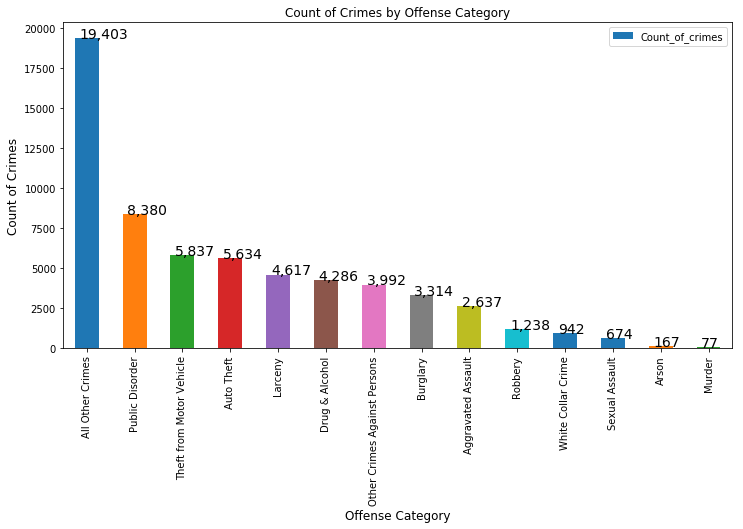

In [136]:
ax = Cluster_0_all_crime.plot.bar(x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category',figsize=(12, 6))
ax.set_xlabel("Offense Category", fontsize=12)
ax.set_ylabel("Count of Crimes", fontsize=12)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:,}'.format(height), (x + 0.1 , y + height + 0.1), size = 14)

plt.show()

- Excluding the 'All other Crimes', the primary category of crimes are public disorder, steal related (theft, larceny, burglary) and drug & alcohol
- The amount of Robbery and murder is relatively small

Count of crimes by year

In [109]:
Cluster_0_crime_by_year = Cluster_0_crime.groupby(['YEAR','OFFENSE_CATEGORY_NAME'])['OFFENSE_CATEGORY_NAME'].count()
Cluster_0_crime_by_year= Cluster_0_crime_by_year.to_frame()
Cluster_0_crime_by_year.columns = ['Count_of_crimes']
Cluster_0_crime_by_year = Cluster_0_crime_by_year.reset_index()
#Cluster_0_all_crime = Cluster_0_all_crime.sort_values(by = 'Count_of_crimes', ascending = False)


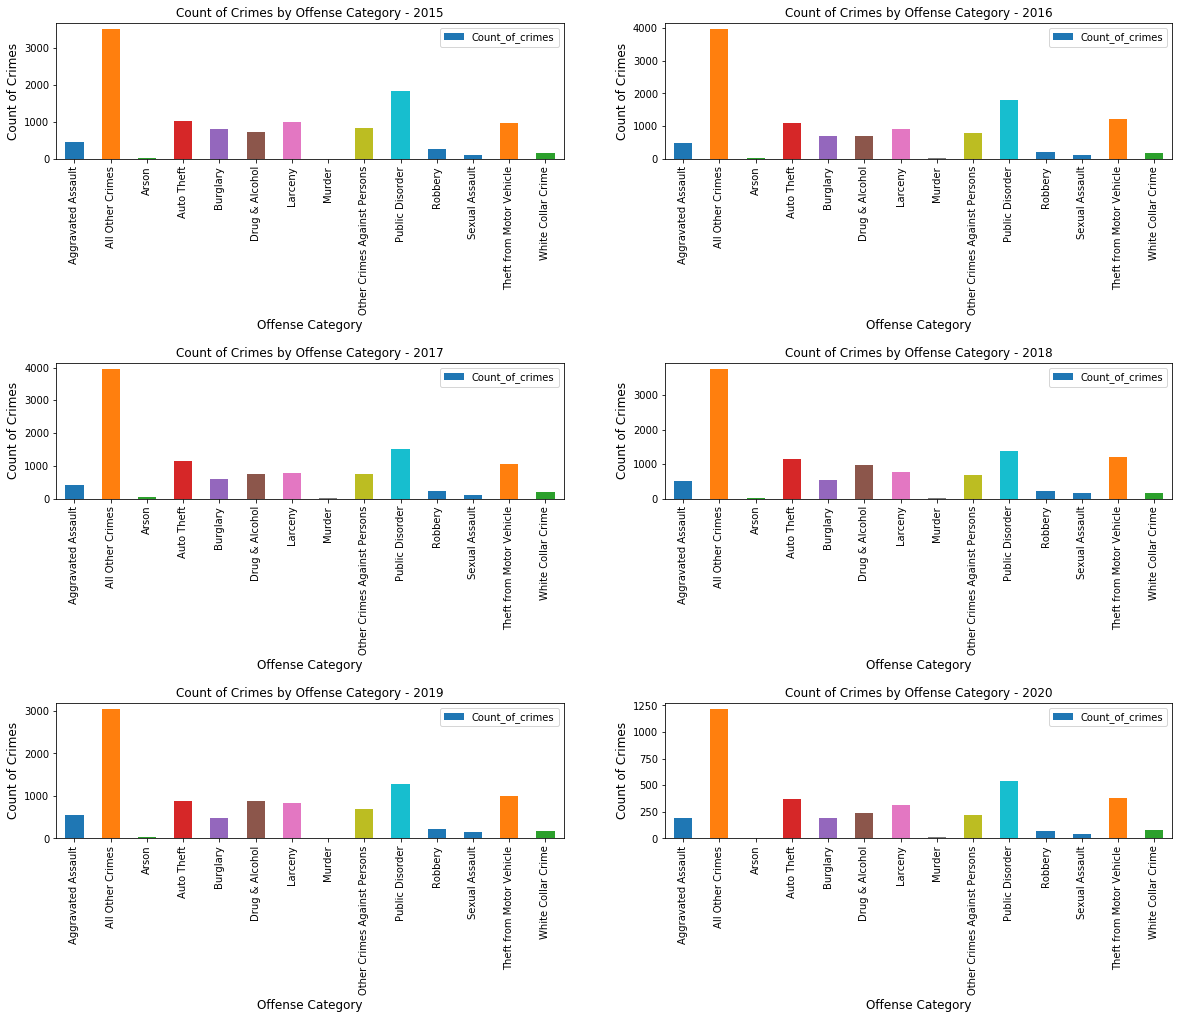

In [110]:
fig = plt.figure(figsize = (20,15)) # create figure

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5) # set up the white space (height) between subplots

ax0 = fig.add_subplot(3, 2, 1) # add subplot 1 (3 row, 2 columns, first plot)
ax1 = fig.add_subplot(3, 2, 2) # add subplot 2 (3 row, 2 columns, second plot). 
ax2 = fig.add_subplot(3, 2, 3) # add subplot 3 (3 row, 2 columns, third plot)
ax3 = fig.add_subplot(3, 2, 4) # add subplot 4 (3 row, 2 columns, fourth plot). 
ax4 = fig.add_subplot(3, 2, 5) # add subplot 5 (3 row, 2 columns, fifth plot)
ax5 = fig.add_subplot(3, 2, 6) # add subplot 6 (3 row, 2 columns, sixth plot). 

Cluster_0_crime_by_year[Cluster_0_crime_by_year['YEAR']==2015].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2015', ax = ax0)
ax0.set_xlabel("Offense Category", fontsize=12)
ax0.set_ylabel("Count of Crimes", fontsize=12)

Cluster_0_crime_by_year[Cluster_0_crime_by_year['YEAR']==2016].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2016', ax = ax1)
ax1.set_xlabel("Offense Category", fontsize=12)
ax1.set_ylabel("Count of Crimes", fontsize=12)

Cluster_0_crime_by_year[Cluster_0_crime_by_year['YEAR']==2017].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2017', ax = ax2)
ax2.set_xlabel("Offense Category", fontsize=12)
ax2.set_ylabel("Count of Crimes", fontsize=12)

Cluster_0_crime_by_year[Cluster_0_crime_by_year['YEAR']==2018].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2018', ax = ax3)
ax3.set_xlabel("Offense Category", fontsize=12)
ax3.set_ylabel("Count of Crimes", fontsize=12)

Cluster_0_crime_by_year[Cluster_0_crime_by_year['YEAR']==2019].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2019', ax = ax4)
ax4.set_xlabel("Offense Category", fontsize=12)
ax4.set_ylabel("Count of Crimes", fontsize=12)

Cluster_0_crime_by_year[Cluster_0_crime_by_year['YEAR']==2020].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2020', ax = ax5)
ax5.set_xlabel("Offense Category", fontsize=12)
ax5.set_ylabel("Count of Crimes", fontsize=12)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5)

plt.show()

 - There is no change of trend in terms of primary crime categories
 - Public disorder, steal (theft, larceny, bulglary), and drug & alcohol are the most common ones

#### Analysis of Cluter 1

- Count of Crimes by Category 
- Count of Crimes by Year

Count of Crimes by Category

In [111]:
Cluster_1_all_crime = Cluster_1_crime.groupby('OFFENSE_CATEGORY_NAME')['OFFENSE_CATEGORY_NAME'].count()
Cluster_1_all_crime = Cluster_1_all_crime.to_frame()
Cluster_1_all_crime.columns = ['Count_of_crimes']
Cluster_1_all_crime = Cluster_1_all_crime.reset_index()
Cluster_1_all_crime = Cluster_1_all_crime.sort_values(by = 'Count_of_crimes', ascending = False)

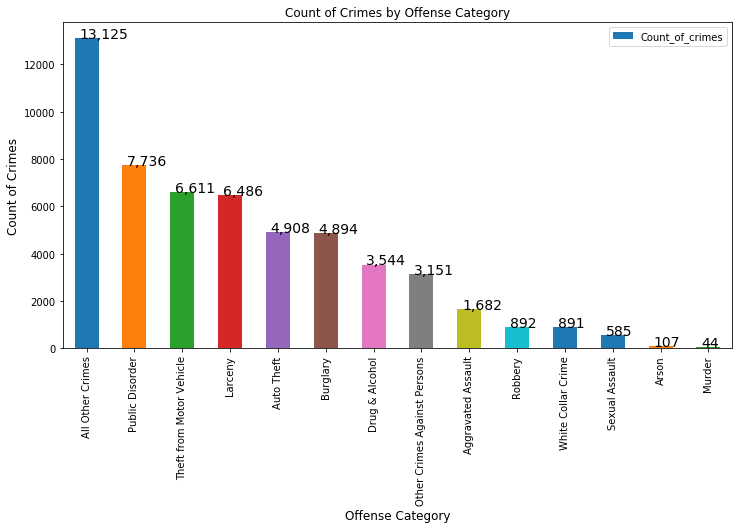

In [137]:
ax = Cluster_1_all_crime.plot.bar(x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category',figsize=(12, 6))
ax.set_xlabel("Offense Category", fontsize=12)
ax.set_ylabel("Count of Crimes", fontsize=12)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:,}'.format(height), (x + 0.1 , y + height + 0.1), size = 14)

plt.show()

 - Unlike Cluster 0, Cluster 1 has less "All other Crimes" (13,125 vs 19,403)
 - Public Disorder, steal related (theft, larceny, burglary) and drug & alcohol are the primary crimes

Count of crimes by year

In [113]:
Cluster_1_crime_by_year = Cluster_1_crime.groupby(['YEAR','OFFENSE_CATEGORY_NAME'])['OFFENSE_CATEGORY_NAME'].count()
Cluster_1_crime_by_year= Cluster_1_crime_by_year.to_frame()
Cluster_1_crime_by_year.columns = ['Count_of_crimes']
Cluster_1_crime_by_year = Cluster_1_crime_by_year.reset_index()

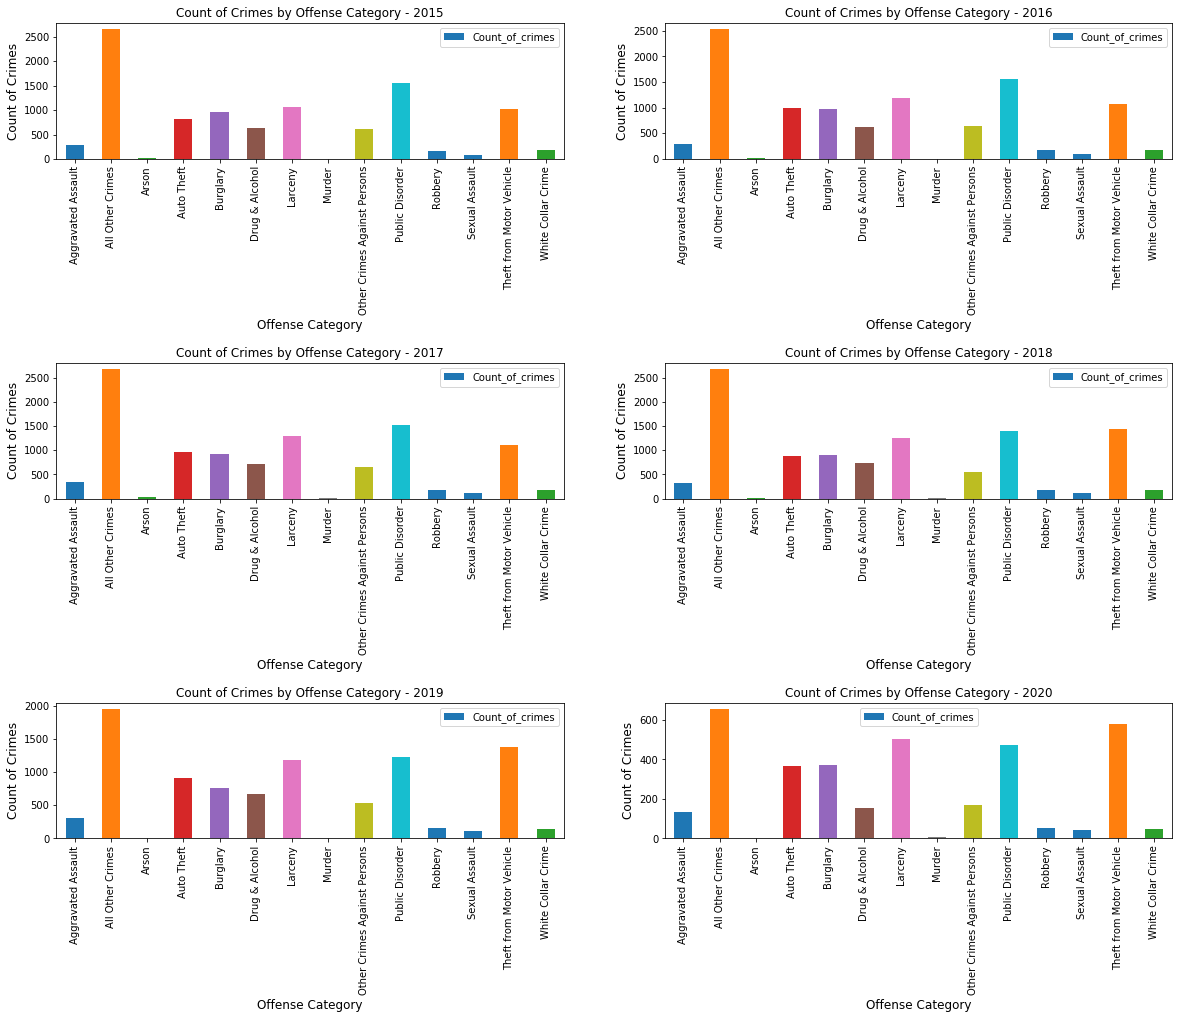

In [114]:
fig = plt.figure(figsize = (20,15)) # create figure

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5) # set up the white space (height) between subplots

ax0 = fig.add_subplot(3, 2, 1) # add subplot 1 (3 row, 2 columns, first plot)
ax1 = fig.add_subplot(3, 2, 2) # add subplot 2 (3 row, 2 columns, second plot). 
ax2 = fig.add_subplot(3, 2, 3) # add subplot 3 (3 row, 2 columns, third plot)
ax3 = fig.add_subplot(3, 2, 4) # add subplot 4 (3 row, 2 columns, fourth plot). 
ax4 = fig.add_subplot(3, 2, 5) # add subplot 5 (3 row, 2 columns, fifth plot)
ax5 = fig.add_subplot(3, 2, 6) # add subplot 6 (3 row, 2 columns, sixth plot). 

Cluster_1_crime_by_year[Cluster_1_crime_by_year['YEAR']==2015].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2015', ax = ax0)
ax0.set_xlabel("Offense Category", fontsize=12)
ax0.set_ylabel("Count of Crimes", fontsize=12)

Cluster_1_crime_by_year[Cluster_1_crime_by_year['YEAR']==2016].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2016', ax = ax1)
ax1.set_xlabel("Offense Category", fontsize=12)
ax1.set_ylabel("Count of Crimes", fontsize=12)

Cluster_1_crime_by_year[Cluster_1_crime_by_year['YEAR']==2017].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2017', ax = ax2)
ax2.set_xlabel("Offense Category", fontsize=12)
ax2.set_ylabel("Count of Crimes", fontsize=12)

Cluster_1_crime_by_year[Cluster_1_crime_by_year['YEAR']==2018].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2018', ax = ax3)
ax3.set_xlabel("Offense Category", fontsize=12)
ax3.set_ylabel("Count of Crimes", fontsize=12)

Cluster_1_crime_by_year[Cluster_1_crime_by_year['YEAR']==2019].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2019', ax = ax4)
ax4.set_xlabel("Offense Category", fontsize=12)
ax4.set_ylabel("Count of Crimes", fontsize=12)

Cluster_1_crime_by_year[Cluster_1_crime_by_year['YEAR']==2020].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2020', ax = ax5)
ax5.set_xlabel("Offense Category", fontsize=12)
ax5.set_ylabel("Count of Crimes", fontsize=12)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5)

plt.show()

 - Larceny and Theft from Motor Vehicle increase continuously

#### Analysis of Cluter 2

- Count of Crimes by Category 
- Count of Crimes by Year

Count of Crimes by Category

In [115]:
Cluster_2_all_crime = Cluster_2_crime.groupby('OFFENSE_CATEGORY_NAME')['OFFENSE_CATEGORY_NAME'].count()
Cluster_2_all_crime = Cluster_2_all_crime.to_frame()
Cluster_2_all_crime.columns = ['Count_of_crimes']
Cluster_2_all_crime = Cluster_2_all_crime.reset_index()
Cluster_2_all_crime = Cluster_2_all_crime.sort_values(by = 'Count_of_crimes', ascending = False)

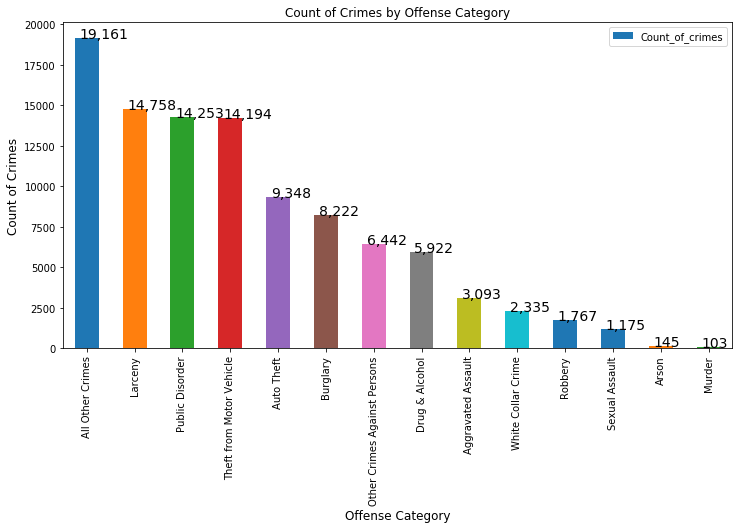

In [138]:
ax = Cluster_2_all_crime.plot.bar(x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category',figsize=(12, 6))
ax.set_xlabel("Offense Category", fontsize=12)
ax.set_ylabel("Count of Crimes", fontsize=12)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:,}'.format(height), (x + 0.1 , y + height + 0.1), size = 14)

plt.show()

 - In cluster 2, Larceny, Public Disorder, and Theft from Motor Vehicle are very high

Count of crimes by year

In [117]:
Cluster_2_crime_by_year = Cluster_2_crime.groupby(['YEAR','OFFENSE_CATEGORY_NAME'])['OFFENSE_CATEGORY_NAME'].count()
Cluster_2_crime_by_year= Cluster_2_crime_by_year.to_frame()
Cluster_2_crime_by_year.columns = ['Count_of_crimes']
Cluster_2_crime_by_year = Cluster_2_crime_by_year.reset_index()

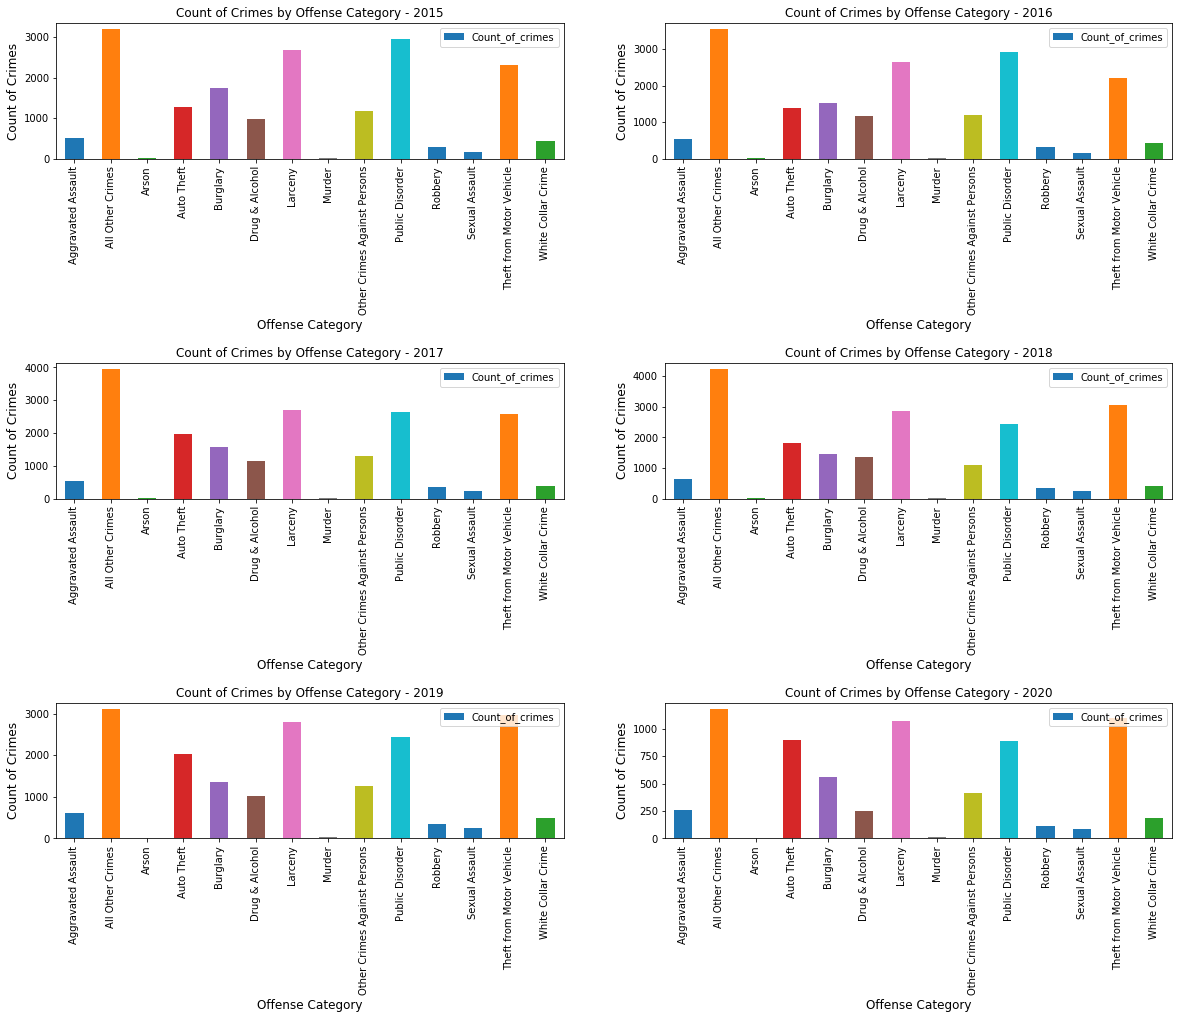

In [118]:
fig = plt.figure(figsize = (20,15)) # create figure

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5) # set up the white space (height) between subplots

ax0 = fig.add_subplot(3, 2, 1) # add subplot 1 (3 row, 2 columns, first plot)
ax1 = fig.add_subplot(3, 2, 2) # add subplot 2 (3 row, 2 columns, second plot). 
ax2 = fig.add_subplot(3, 2, 3) # add subplot 3 (3 row, 2 columns, third plot)
ax3 = fig.add_subplot(3, 2, 4) # add subplot 4 (3 row, 2 columns, fourth plot). 
ax4 = fig.add_subplot(3, 2, 5) # add subplot 5 (3 row, 2 columns, fifth plot)
ax5 = fig.add_subplot(3, 2, 6) # add subplot 6 (3 row, 2 columns, sixth plot). 

Cluster_2_crime_by_year[Cluster_2_crime_by_year['YEAR']==2015].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2015', ax = ax0)
ax0.set_xlabel("Offense Category", fontsize=12)
ax0.set_ylabel("Count of Crimes", fontsize=12)

Cluster_2_crime_by_year[Cluster_2_crime_by_year['YEAR']==2016].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2016', ax = ax1)
ax1.set_xlabel("Offense Category", fontsize=12)
ax1.set_ylabel("Count of Crimes", fontsize=12)

Cluster_2_crime_by_year[Cluster_2_crime_by_year['YEAR']==2017].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2017', ax = ax2)
ax2.set_xlabel("Offense Category", fontsize=12)
ax2.set_ylabel("Count of Crimes", fontsize=12)

Cluster_2_crime_by_year[Cluster_2_crime_by_year['YEAR']==2018].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2018', ax = ax3)
ax3.set_xlabel("Offense Category", fontsize=12)
ax3.set_ylabel("Count of Crimes", fontsize=12)

Cluster_2_crime_by_year[Cluster_2_crime_by_year['YEAR']==2019].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2019', ax = ax4)
ax4.set_xlabel("Offense Category", fontsize=12)
ax4.set_ylabel("Count of Crimes", fontsize=12)

Cluster_2_crime_by_year[Cluster_2_crime_by_year['YEAR']==2020].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2020', ax = ax5)
ax5.set_xlabel("Offense Category", fontsize=12)
ax5.set_ylabel("Count of Crimes", fontsize=12)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5)

plt.show()

 - Larceny and Theft from Motor Vehicle increase continuously over the years

#### Analysis of Cluter 3

- Count of Crimes by Category 
- Count of Crimes by Year

Count of Crimes by Category

In [119]:
Cluster_3_all_crime = Cluster_3_crime.groupby('OFFENSE_CATEGORY_NAME')['OFFENSE_CATEGORY_NAME'].count()
Cluster_3_all_crime = Cluster_3_all_crime.to_frame()
Cluster_3_all_crime.columns = ['Count_of_crimes']
Cluster_3_all_crime = Cluster_3_all_crime.reset_index()
Cluster_3_all_crime = Cluster_3_all_crime.sort_values(by = 'Count_of_crimes', ascending = False)

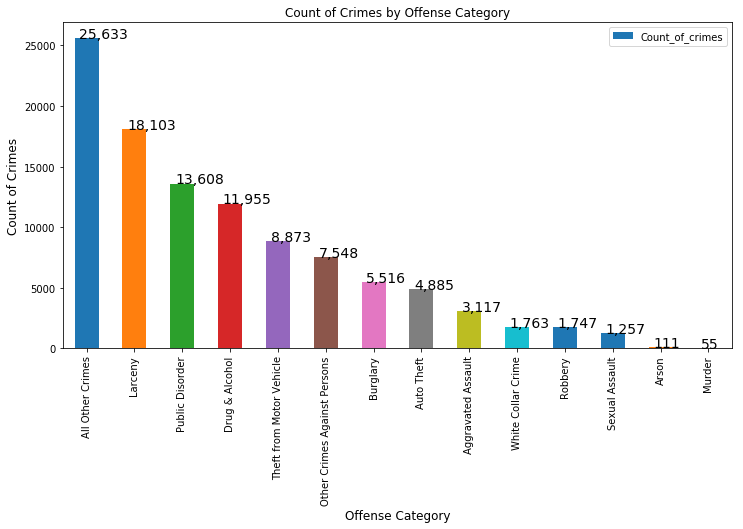

In [139]:
ax = Cluster_3_all_crime.plot.bar(x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category',figsize=(12, 6))
ax.set_xlabel("Offense Category", fontsize=12)
ax.set_ylabel("Count of Crimes", fontsize=12)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:,}'.format(height), (x + 0.1 , y + height + 0.1), size = 14)
    
plt.show()

- Larceny, Public Disorder and Drug & Alcohol are very high

Count of crimes by year

In [121]:
Cluster_3_crime_by_year = Cluster_3_crime.groupby(['YEAR','OFFENSE_CATEGORY_NAME'])['OFFENSE_CATEGORY_NAME'].count()
Cluster_3_crime_by_year= Cluster_3_crime_by_year.to_frame()
Cluster_3_crime_by_year.columns = ['Count_of_crimes']
Cluster_3_crime_by_year = Cluster_3_crime_by_year.reset_index()

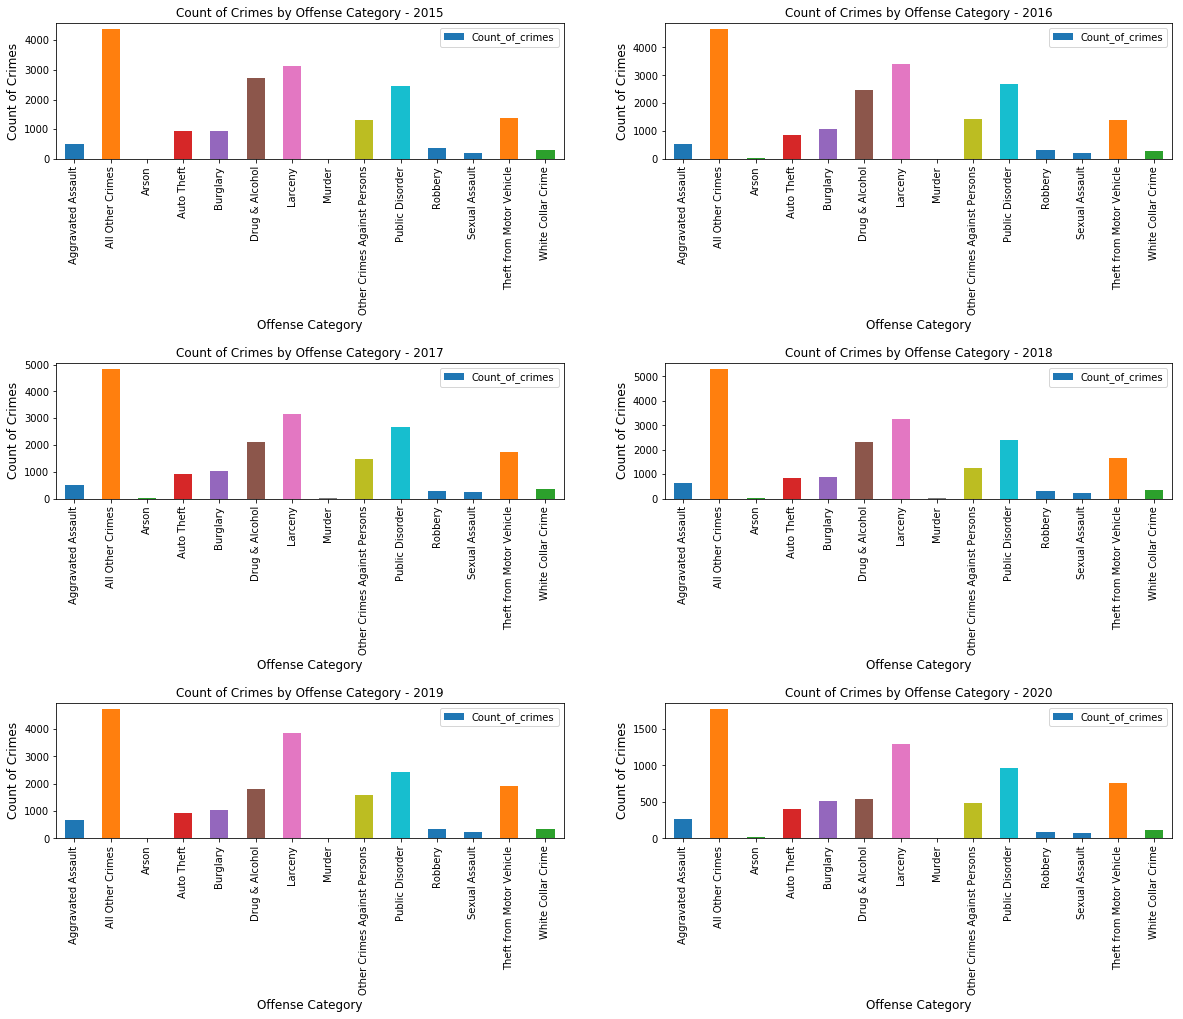

In [122]:
fig = plt.figure(figsize = (20,15)) # create figure

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5) # set up the white space (height) between subplots

ax0 = fig.add_subplot(3, 2, 1) # add subplot 1 (3 row, 2 columns, first plot)
ax1 = fig.add_subplot(3, 2, 2) # add subplot 2 (3 row, 2 columns, second plot). 
ax2 = fig.add_subplot(3, 2, 3) # add subplot 3 (3 row, 2 columns, third plot)
ax3 = fig.add_subplot(3, 2, 4) # add subplot 4 (3 row, 2 columns, fourth plot). 
ax4 = fig.add_subplot(3, 2, 5) # add subplot 5 (3 row, 2 columns, fifth plot)
ax5 = fig.add_subplot(3, 2, 6) # add subplot 6 (3 row, 2 columns, sixth plot). 

Cluster_3_crime_by_year[Cluster_3_crime_by_year['YEAR']==2015].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2015', ax = ax0)
ax0.set_xlabel("Offense Category", fontsize=12)
ax0.set_ylabel("Count of Crimes", fontsize=12)

Cluster_3_crime_by_year[Cluster_3_crime_by_year['YEAR']==2016].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2016', ax = ax1)
ax1.set_xlabel("Offense Category", fontsize=12)
ax1.set_ylabel("Count of Crimes", fontsize=12)

Cluster_3_crime_by_year[Cluster_3_crime_by_year['YEAR']==2017].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2017', ax = ax2)
ax2.set_xlabel("Offense Category", fontsize=12)
ax2.set_ylabel("Count of Crimes", fontsize=12)

Cluster_3_crime_by_year[Cluster_3_crime_by_year['YEAR']==2018].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2018', ax = ax3)
ax3.set_xlabel("Offense Category", fontsize=12)
ax3.set_ylabel("Count of Crimes", fontsize=12)

Cluster_3_crime_by_year[Cluster_3_crime_by_year['YEAR']==2019].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2019', ax = ax4)
ax4.set_xlabel("Offense Category", fontsize=12)
ax4.set_ylabel("Count of Crimes", fontsize=12)

Cluster_3_crime_by_year[Cluster_3_crime_by_year['YEAR']==2020].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2020', ax = ax5)
ax5.set_xlabel("Offense Category", fontsize=12)
ax5.set_ylabel("Count of Crimes", fontsize=12)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5)

plt.show()

- Larceny and Theft from Motor Vehicle increase continuously over the years
- Drug & Alcohol decrease over the years

#### Analysis of Cluter 4

- Count of Crimes by Category 
- Count of Crimes by Year

Count of Crimes by Category

In [123]:
Cluster_4_all_crime = Cluster_4_crime.groupby('OFFENSE_CATEGORY_NAME')['OFFENSE_CATEGORY_NAME'].count()
Cluster_4_all_crime = Cluster_4_all_crime.to_frame()
Cluster_4_all_crime.columns = ['Count_of_crimes']
Cluster_4_all_crime = Cluster_4_all_crime.reset_index()
Cluster_4_all_crime = Cluster_4_all_crime.sort_values(by = 'Count_of_crimes', ascending = False)

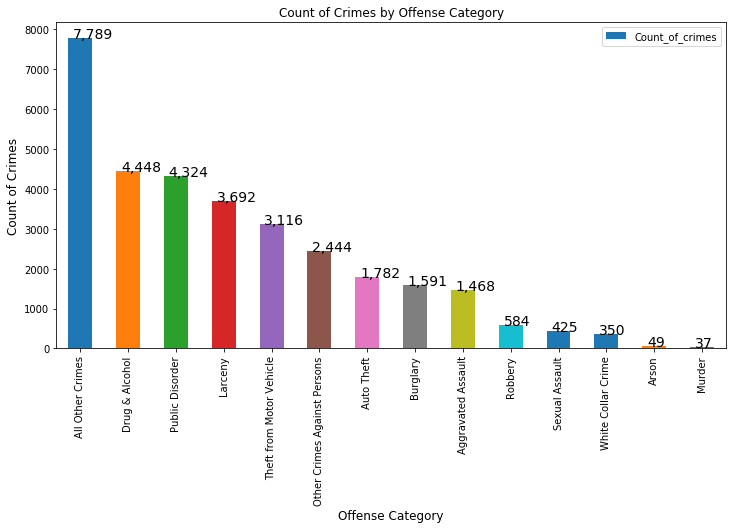

In [140]:
ax = Cluster_4_all_crime.plot.bar(x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category',figsize=(12, 6))
ax.set_xlabel("Offense Category", fontsize=12)
ax.set_ylabel("Count of Crimes", fontsize=12)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:,}'.format(height), (x + 0.1 , y + height + 0.1), size = 14)
    
plt.show()

 - Cluster 4 has much less crimes, the highest one is less than 10,000
 - Drug & Alcohol, Public Disorder and Larceny are the top three

Count of crimes by year

In [125]:
Cluster_4_crime_by_year = Cluster_4_crime.groupby(['YEAR','OFFENSE_CATEGORY_NAME'])['OFFENSE_CATEGORY_NAME'].count()
Cluster_4_crime_by_year = Cluster_4_crime_by_year.to_frame()
Cluster_4_crime_by_year.columns = ['Count_of_crimes']
Cluster_4_crime_by_year = Cluster_4_crime_by_year.reset_index()

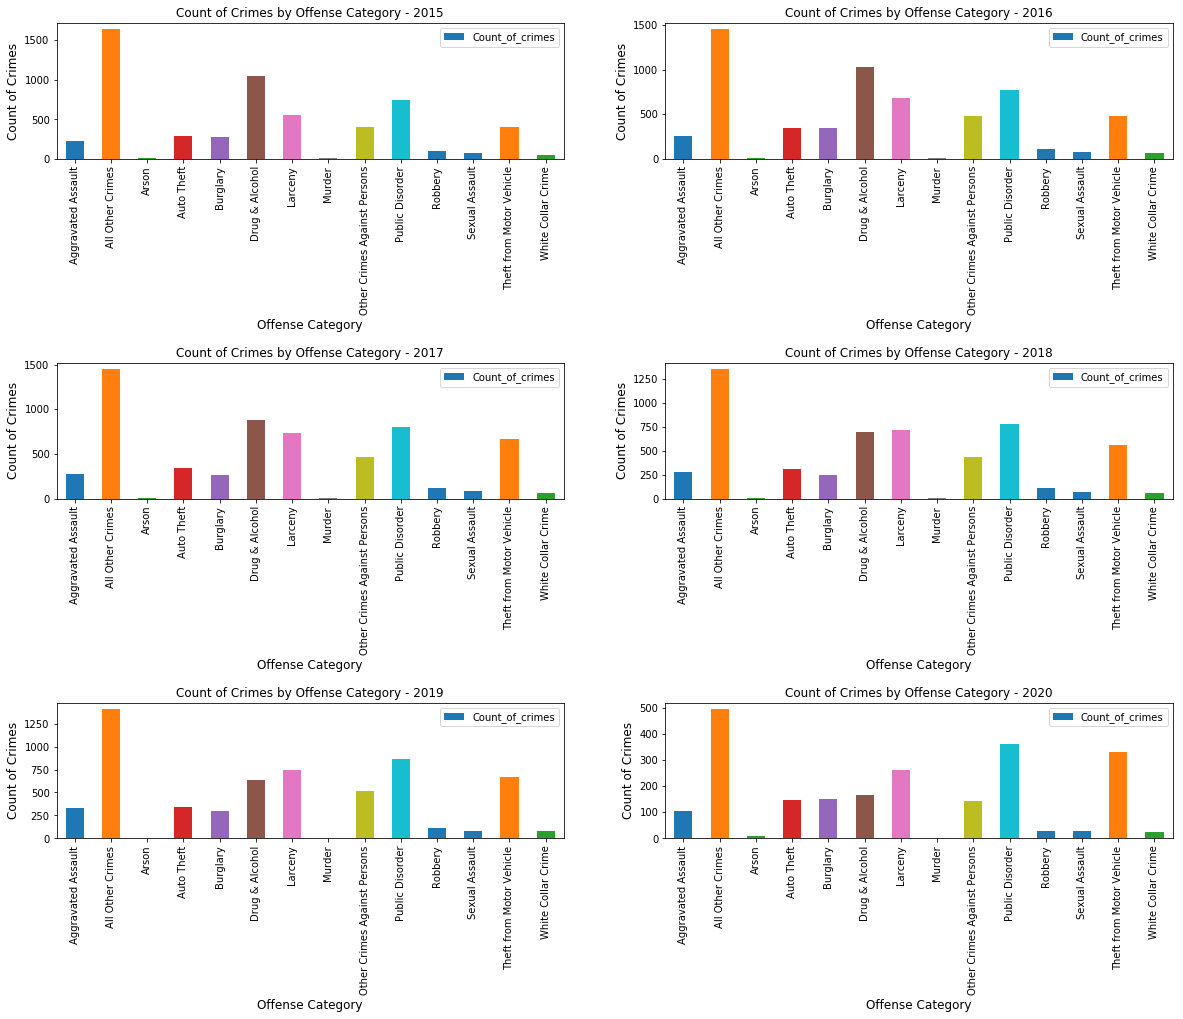

In [126]:
fig = plt.figure(figsize = (20,15)) # create figure

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5) # set up the white space (height) between subplots

ax0 = fig.add_subplot(3, 2, 1) # add subplot 1 (3 row, 2 columns, first plot)
ax1 = fig.add_subplot(3, 2, 2) # add subplot 2 (3 row, 2 columns, second plot). 
ax2 = fig.add_subplot(3, 2, 3) # add subplot 3 (3 row, 2 columns, third plot)
ax3 = fig.add_subplot(3, 2, 4) # add subplot 4 (3 row, 2 columns, fourth plot). 
ax4 = fig.add_subplot(3, 2, 5) # add subplot 5 (3 row, 2 columns, fifth plot)
ax5 = fig.add_subplot(3, 2, 6) # add subplot 6 (3 row, 2 columns, sixth plot). 

Cluster_4_crime_by_year[Cluster_4_crime_by_year['YEAR']==2015].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2015', ax = ax0)
ax0.set_xlabel("Offense Category", fontsize=12)
ax0.set_ylabel("Count of Crimes", fontsize=12)

Cluster_4_crime_by_year[Cluster_4_crime_by_year['YEAR']==2016].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2016', ax = ax1)
ax1.set_xlabel("Offense Category", fontsize=12)
ax1.set_ylabel("Count of Crimes", fontsize=12)

Cluster_4_crime_by_year[Cluster_4_crime_by_year['YEAR']==2017].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2017', ax = ax2)
ax2.set_xlabel("Offense Category", fontsize=12)
ax2.set_ylabel("Count of Crimes", fontsize=12)

Cluster_4_crime_by_year[Cluster_4_crime_by_year['YEAR']==2018].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2018', ax = ax3)
ax3.set_xlabel("Offense Category", fontsize=12)
ax3.set_ylabel("Count of Crimes", fontsize=12)

Cluster_4_crime_by_year[Cluster_4_crime_by_year['YEAR']==2019].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2019', ax = ax4)
ax4.set_xlabel("Offense Category", fontsize=12)
ax4.set_ylabel("Count of Crimes", fontsize=12)

Cluster_4_crime_by_year[Cluster_4_crime_by_year['YEAR']==2020].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2020', ax = ax5)
ax5.set_xlabel("Offense Category", fontsize=12)
ax5.set_ylabel("Count of Crimes", fontsize=12)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5)

plt.show()

- Drug & Alcohol decreases over the years

#### Analysis of Cluter 5

- Count of Crimes by Category 
- Count of Crimes by Year

Count of Crimes by Category

In [127]:
Cluster_5_all_crime = Cluster_5_crime.groupby('OFFENSE_CATEGORY_NAME')['OFFENSE_CATEGORY_NAME'].count()
Cluster_5_all_crime = Cluster_5_all_crime.to_frame()
Cluster_5_all_crime.columns = ['Count_of_crimes']
Cluster_5_all_crime = Cluster_5_all_crime.reset_index()
Cluster_5_all_crime = Cluster_5_all_crime.sort_values(by = 'Count_of_crimes', ascending = False)

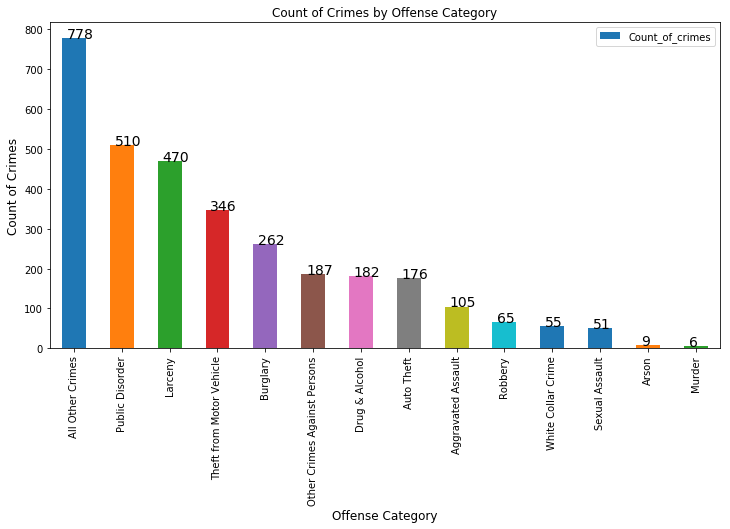

In [141]:
ax = Cluster_5_all_crime.plot.bar(x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category',figsize=(12, 6))
ax.set_xlabel("Offense Category", fontsize=12)
ax.set_ylabel("Count of Crimes", fontsize=12)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:,}'.format(height), (x + 0.1 , y + height + 0.1), size = 14)
    
plt.show()

 - Cluster 5 is the best cluster, the biggest one is still small than 1000
 - Top three are Public Disorder, Larceny, and Theft from Motor Vehicle

Count of crimes by year

In [129]:
Cluster_5_crime_by_year = Cluster_5_crime.groupby(['YEAR','OFFENSE_CATEGORY_NAME'])['OFFENSE_CATEGORY_NAME'].count()
Cluster_5_crime_by_year = Cluster_5_crime_by_year.to_frame()
Cluster_5_crime_by_year.columns = ['Count_of_crimes']
Cluster_5_crime_by_year = Cluster_5_crime_by_year.reset_index()

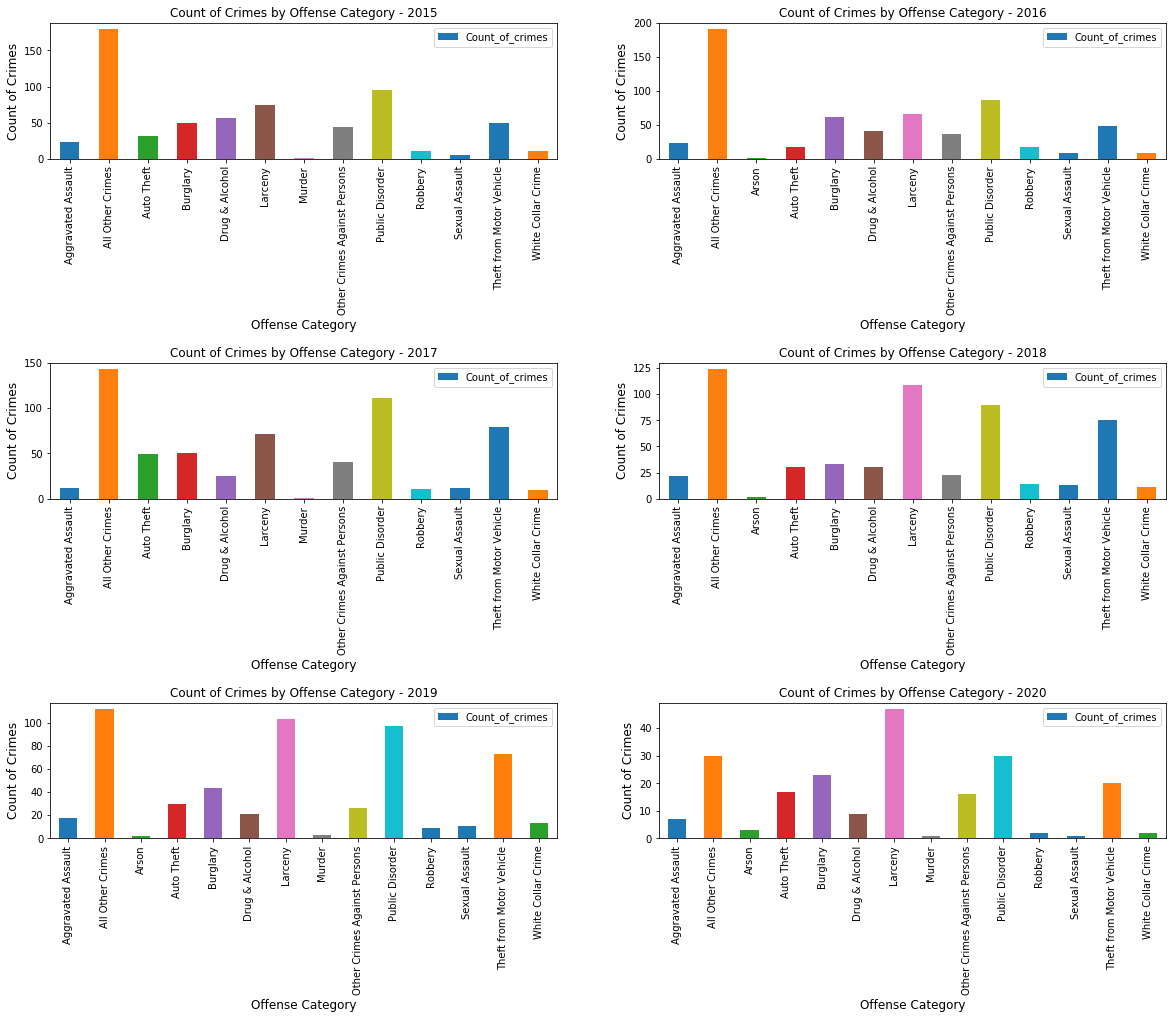

In [130]:
fig = plt.figure(figsize = (20,15)) # create figure

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5) # set up the white space (height) between subplots

ax0 = fig.add_subplot(3, 2, 1) # add subplot 1 (3 row, 2 columns, first plot)
ax1 = fig.add_subplot(3, 2, 2) # add subplot 2 (3 row, 2 columns, second plot). 
ax2 = fig.add_subplot(3, 2, 3) # add subplot 3 (3 row, 2 columns, third plot)
ax3 = fig.add_subplot(3, 2, 4) # add subplot 4 (3 row, 2 columns, fourth plot). 
ax4 = fig.add_subplot(3, 2, 5) # add subplot 5 (3 row, 2 columns, fifth plot)
ax5 = fig.add_subplot(3, 2, 6) # add subplot 6 (3 row, 2 columns, sixth plot). 

Cluster_5_crime_by_year[Cluster_5_crime_by_year['YEAR']==2015].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2015', ax = ax0)
ax0.set_xlabel("Offense Category", fontsize=12)
ax0.set_ylabel("Count of Crimes", fontsize=12)

Cluster_5_crime_by_year[Cluster_5_crime_by_year['YEAR']==2016].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2016', ax = ax1)
ax1.set_xlabel("Offense Category", fontsize=12)
ax1.set_ylabel("Count of Crimes", fontsize=12)

Cluster_5_crime_by_year[Cluster_5_crime_by_year['YEAR']==2017].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2017', ax = ax2)
ax2.set_xlabel("Offense Category", fontsize=12)
ax2.set_ylabel("Count of Crimes", fontsize=12)

Cluster_5_crime_by_year[Cluster_5_crime_by_year['YEAR']==2018].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2018', ax = ax3)
ax3.set_xlabel("Offense Category", fontsize=12)
ax3.set_ylabel("Count of Crimes", fontsize=12)

Cluster_5_crime_by_year[Cluster_5_crime_by_year['YEAR']==2019].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2019', ax = ax4)
ax4.set_xlabel("Offense Category", fontsize=12)
ax4.set_ylabel("Count of Crimes", fontsize=12)

Cluster_5_crime_by_year[Cluster_5_crime_by_year['YEAR']==2020].plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', y = 'Count_of_crimes' , title = 'Count of Crimes by Offense Category - 2020', ax = ax5)
ax5.set_xlabel("Offense Category", fontsize=12)
ax5.set_ylabel("Count of Crimes", fontsize=12)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5)

plt.show()

 - Larceny and Public Disorder increase over the years